In [2]:
# Data Manipulation and Preprocessing
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, PolynomialFeatures

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go

# Model Building and Training
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.arima.model import ARIMA

# Model Evaluation and Selection
from sklearn.model_selection import (
    train_test_split, 
    GridSearchCV, 
    RandomizedSearchCV, 
    cross_val_score, 
    learning_curve
)
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Hyperparameter Tuning
import optuna

# Pipeline
from sklearn.pipeline import Pipeline, make_pipeline

# Model Saving and Loading
import joblib



In [2]:
data = pd.read_csv('housing_new.csv')
data = data.drop(columns=['Unnamed: 0.1', 'Unnamed: 0'])
data = data[['new_date','flat_type', 'district', 'range_numeric' ,'floor_area_sqm', 'lease_commence_date', 'resale_price',]]

In [3]:
data.head()

new_date flat_type    district  range_numeric  floor_area_sqm  \
0  1990.083333    1 ROOM  North-East           11.0            31.0   
1  1990.083333    1 ROOM  North-East            5.0            31.0   
2  1990.083333    1 ROOM  North-East           11.0            31.0   
3  1990.083333    1 ROOM  North-East            8.0            31.0   
4  1990.083333    3 ROOM  North-East            5.0            73.0   

   lease_commence_date  resale_price  
0                 1977        9000.0  
1                 1977        6000.0  
2                 1977        8000.0  
3                 1977        6000.0  
4                 1976       47200.0

In [4]:
loaded_preprocessor = joblib.load('preprocessor.pkl')

In [5]:

transformed_data = loaded_preprocessor.transform(data)
# Extract feature names from the transformers
categorical_columns = ['district', 'flat_type']
numerical_columns = [ 'floor_area_sqm', 'range_numeric']

num_feature_names = numerical_columns
cat_feature_names = loaded_preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_columns)
remainder_feature_names = [col for col in data.columns if col not in numerical_columns + categorical_columns]

# Combine all feature names
all_feature_names = list(num_feature_names) + list(cat_feature_names) + remainder_feature_names

# Create a DataFrame with feature names
transformed_data = pd.DataFrame(transformed_data, columns=all_feature_names)


In [6]:
transformed_data.head()

floor_area_sqm  range_numeric  district_East  district_North  \
0       -2.758297       0.663203            0.0             0.0   
1       -2.758297      -0.563772            0.0             0.0   
2       -2.758297       0.663203            0.0             0.0   
3       -2.758297       0.049716            0.0             0.0   
4       -0.843622      -0.563772            0.0             0.0   

   district_North-East  district_West  flat_type_2 ROOM  flat_type_3 ROOM  \
0                  1.0            0.0               0.0               0.0   
1                  1.0            0.0               0.0               0.0   
2                  1.0            0.0               0.0               0.0   
3                  1.0            0.0               0.0               0.0   
4                  1.0            0.0               0.0               1.0   

   flat_type_4 ROOM  flat_type_5 ROOM     new_date  lease_commence_date  \
0               0.0               0.0  1990.083333               1977.0   
1               0.0               0.0  1990.083333               1977.0   
2               0.0               0.0  1990.083333               1977.0   
3               0.0               0.0  1990.083333               1977.0   
4               0.0               0.0  1990.083333               1976.0   

   resale_price  
0        9000.0  
1        6000.0  
2        8000.0  
3        6000.0  
4       47200.0

In [7]:
transformed_data.shape

(869645, 13)

In [8]:

#half_data = transformed_data.sample(frac=0.5, random_state=42)

# Split the sampled data into features and target
#X = half_data.drop('resale_price', axis=1)
#y = half_data['resale_price']

X = transformed_data.drop('resale_price', axis=1)
y= transformed_data['resale_price']
# Split the half data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [24]:


def objective(trial):
    param = {
        'learning_rate': trial.suggest_float('learning_rate', 0.05, 0.2),  # Wider range for fine-tuning
        'n_estimators': trial.suggest_int('n_estimators', 500, 1000),      # Wider range for better exploration
        'max_depth': trial.suggest_int('max_depth', 3, 20),                # Full range of typical tree depths
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),           # Broad exploration for regularization
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0), 
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 1.0),           # L1 regularization
        'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 10.0),        # L2 regularization
        'gamma': trial.suggest_float('gamma', 0.0, 1.0),                   # Minimum loss reduction
    }

    # Initialize the model with current parameters
    model = XGBRegressor(**param, random_state=42)
    
    # Use cross-validation to evaluate the model
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
    rmse = np.sqrt(-scores.mean())  # Convert negative MSE to RMSE
    return rmse

# Run the optimization with a larger number of trials
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)  # Increase trials for better results

# Print the best trial
print("Best Trial:", study.best_trial.params)
print("Best RMSE:", study.best_value)


[I 2025-01-06 16:50:25,042] A new study created in memory with name: no-name-1c7742c5-e5b0-4564-aea9-43bcccf04cf8
[I 2025-01-06 16:51:16,322] Trial 0 finished with value: 29925.609003920395 and parameters: {'learning_rate': 0.1551885747161722, 'n_estimators': 579, 'max_depth': 7, 'subsample': 0.7892915592464479, 'colsample_bytree': 0.5250698697244306, 'min_child_weight': 3, 'reg_alpha': 0.4093801339800691, 'reg_lambda': 5.726900973547426, 'gamma': 0.7985357125997959}. Best is trial 0 with value: 29925.609003920395.
[I 2025-01-06 16:52:01,255] Trial 1 finished with value: 30565.1607097348 and parameters: {'learning_rate': 0.12790371974941028, 'n_estimators': 583, 'max_depth': 6, 'subsample': 0.7256045846170733, 'colsample_bytree': 0.8060719980470417, 'min_child_weight': 1, 'reg_alpha': 0.6114219366843138, 'reg_lambda': 8.426519567888327, 'gamma': 0.8819264397290669}. Best is trial 0 with value: 29925.609003920395.
[I 2025-01-06 16:55:41,702] Trial 2 finished with value: 29134.4570434745

Best Trial: {'learning_rate': 0.12040362823749595, 'n_estimators': 978, 'max_depth': 10, 'subsample': 0.9719490955047035, 'colsample_bytree': 0.550568778436104, 'min_child_weight': 2, 'reg_alpha': 0.3925634761703144, 'reg_lambda': 4.39773618651876, 'gamma': 0.5942656411394749}
Best RMSE: 28372.469460457673


In [25]:
optuna.visualization.plot_param_importances(study).show()
optuna.visualization.plot_optimization_history(study).show()

In [29]:
best_params = study.best_trial.params
final_model = XGBRegressor(**best_params, random_state=42)


Cross-Validation R^2 Scores: [0.97088992 0.97065881 0.97108072 0.97086779 0.97055792]
Mean R^2: 0.9708, Std: 0.0002
Test MSE: 803847873.0223
Test MAE: 18234.1906
Test R^2: 0.9708
Explained Variance: 0.9708
Mean Absolute Percentage Error (MAPE): 0.0648


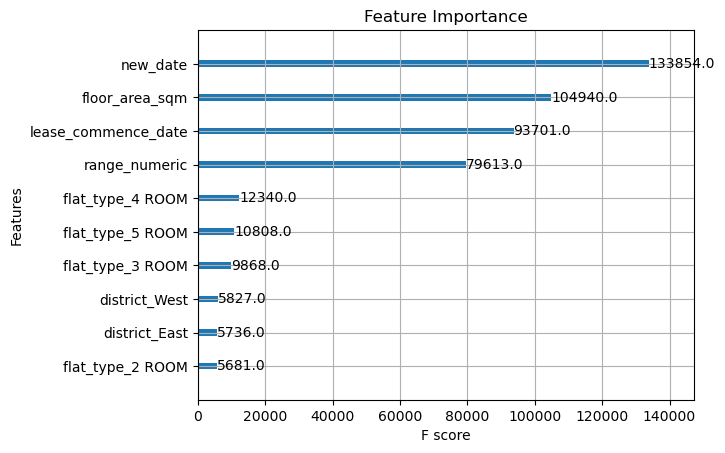

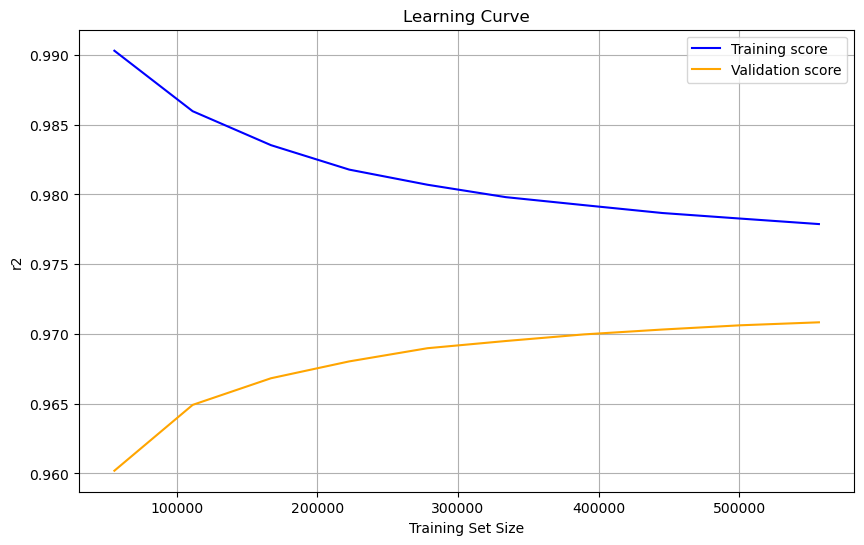

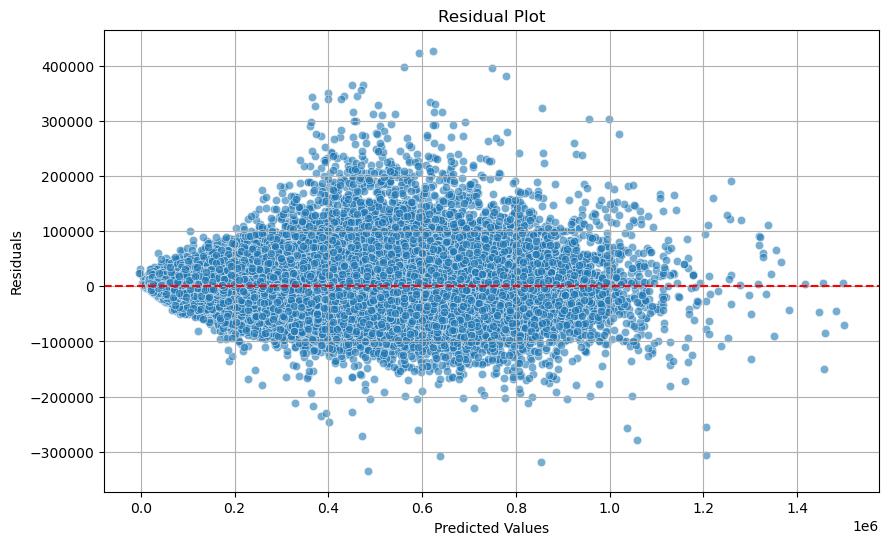

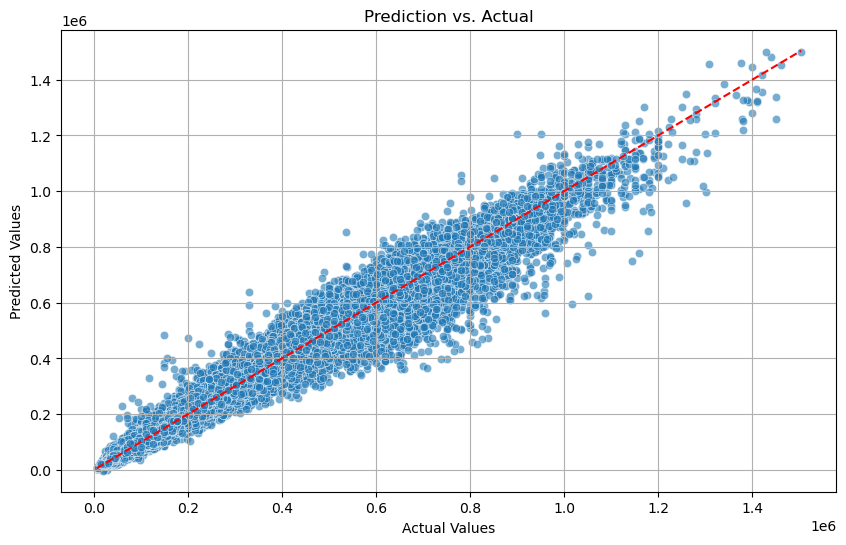

c:\Users\firas\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.



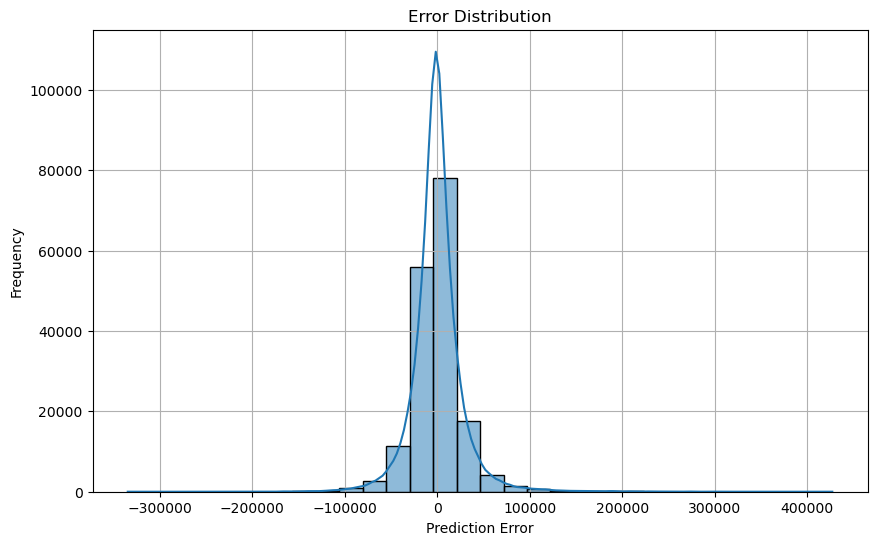

In [30]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import learning_curve, KFold, cross_val_score
from sklearn.metrics import (
    mean_squared_error, mean_absolute_error, r2_score,
    explained_variance_score, mean_absolute_percentage_error
)
from xgboost import plot_importance

# Plot Learning Curve
def plot_learning_curve(estimator, X, y, cv, scoring, train_sizes=np.linspace(0.1, 1.0, 10)):
    train_sizes, train_scores, valid_scores = learning_curve(
        estimator, X, y, cv=cv, scoring=scoring, train_sizes=train_sizes, n_jobs=-1
    )
    train_mean = np.mean(train_scores, axis=1)
    valid_mean = np.mean(valid_scores, axis=1)

    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes, train_mean, label="Training score", color="blue")
    plt.plot(train_sizes, valid_mean, label="Validation score", color="orange")
    plt.title("Learning Curve")
    plt.xlabel("Training Set Size")
    plt.ylabel(scoring)
    plt.legend(loc="best")
    plt.grid()
    plt.show()

# Residual Plot
def plot_residuals(y_true, y_pred):
    residuals = y_true - y_pred
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=y_pred, y=residuals, alpha=0.6)
    plt.axhline(0, color='red', linestyle='--')
    plt.title("Residual Plot")
    plt.xlabel("Predicted Values")
    plt.ylabel("Residuals")
    plt.grid()
    plt.show()

# Prediction vs. Actual Plot
def plot_predictions(y_true, y_pred):
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=y_true, y=y_pred, alpha=0.6)
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], color='red', linestyle='--')
    plt.title("Prediction vs. Actual")
    plt.xlabel("Actual Values")
    plt.ylabel("Predicted Values")
    plt.grid()
    plt.show()

# Error Distribution Plot
def plot_error_distribution(y_true, y_pred):
    errors = y_true - y_pred
    plt.figure(figsize=(10, 6))
    sns.histplot(errors, bins=30, kde=True)
    plt.title("Error Distribution")
    plt.xlabel("Prediction Error")
    plt.ylabel("Frequency")
    plt.grid()
    plt.show()

# Perform K-Fold Cross-Validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(final_model, X_train, y_train, cv=kf, scoring='r2', n_jobs=-1)
print(f"Cross-Validation R^2 Scores: {scores}")
print(f"Mean R^2: {np.mean(scores):.4f}, Std: {np.std(scores):.4f}")

# Fit model on full training data and evaluate on test set
final_model.fit(X_train, y_train)
y_pred = final_model.predict(X_test)

# Test Metrics
print(f"Test MSE: {mean_squared_error(y_test, y_pred):.4f}")
print(f"Test MAE: {mean_absolute_error(y_test, y_pred):.4f}")
print(f"Test R^2: {r2_score(y_test, y_pred):.4f}")
print(f"Explained Variance: {explained_variance_score(y_test, y_pred):.4f}")
print(f"Mean Absolute Percentage Error (MAPE): {mean_absolute_percentage_error(y_test, y_pred):.4f}")

# Plot Feature Importance
plot_importance(final_model, importance_type='weight', max_num_features=10, title="Feature Importance")
plt.show()

# Plot Graphs
plot_learning_curve(final_model, X_train, y_train, cv=kf, scoring='r2')
plot_residuals(y_test, y_pred)
plot_predictions(y_test, y_pred)
plot_error_distribution(y_test, y_pred)


In [31]:
def refined_objective(trial):
    # Use best_params as the center of the refined search space
    best_params = study.best_trial.params
    
    param = {
        'learning_rate': trial.suggest_float(
            'learning_rate', 
            max(0.01, best_params['learning_rate'] - 0.02), 
            min(0.2, best_params['learning_rate'] + 0.02)
        ),
        'n_estimators': trial.suggest_int(
            'n_estimators', 
            max(100, best_params['n_estimators'] - 100), 
            best_params['n_estimators'] + 100
        ),
        'max_depth': trial.suggest_int(
            'max_depth', 
            max(3, best_params['max_depth'] - 2), 
            best_params['max_depth'] + 2
        ),
        'subsample': trial.suggest_float(
            'subsample', 
            max(0.5, best_params['subsample'] - 0.05), 
            min(1.0, best_params['subsample'] + 0.05)
        ),
        'colsample_bytree': trial.suggest_float(
            'colsample_bytree', 
            max(0.5, best_params['colsample_bytree'] - 0.05), 
            min(1.0, best_params['colsample_bytree'] + 0.05)
        ),
        'min_child_weight': trial.suggest_int(
            'min_child_weight', 
            max(1, best_params['min_child_weight'] - 2), 
            best_params['min_child_weight'] + 2
        ),
        'reg_alpha': trial.suggest_float(
            'reg_alpha', 
            max(0.0, best_params['reg_alpha'] - 0.02), 
            best_params['reg_alpha'] + 0.02
        ),
        'reg_lambda': trial.suggest_float(
            'reg_lambda', 
            max(0.0, best_params['reg_lambda'] - 0.5), 
            best_params['reg_lambda'] + 0.5
        ),
        'gamma': trial.suggest_float(
            'gamma', 
            max(0.0, best_params['gamma'] - 0.05), 
            best_params['gamma'] + 0.05
        )
    }

    # Initialize and evaluate the model using cross-validation
    model = XGBRegressor(**param, random_state=42)
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
    rmse = np.sqrt(-scores.mean())
    return rmse

# Create a new study for fine-tuning
refined_study = optuna.create_study(direction='minimize')
refined_study.optimize(refined_objective, n_trials=50)  # More focused fine-tuning with 50 trials

# Print the new best parameters and RMSE
print("Refined Best Trial:", refined_study.best_trial.params)
print("Refined Best RMSE:", refined_study.best_value)


[I 2025-01-06 22:09:33,426] A new study created in memory with name: no-name-cd4f6121-3b45-43b2-a5ff-71e184d4cb0f
[I 2025-01-06 22:11:18,727] Trial 0 finished with value: 28830.205861033748 and parameters: {'learning_rate': 0.11593435474666526, 'n_estimators': 962, 'max_depth': 8, 'subsample': 0.9829322558260262, 'colsample_bytree': 0.552458170048122, 'min_child_weight': 4, 'reg_alpha': 0.3952458116753995, 'reg_lambda': 4.1426956639363235, 'gamma': 0.5483139121261398}. Best is trial 0 with value: 28830.205861033748.
[I 2025-01-06 22:13:34,970] Trial 1 finished with value: 28431.71544342381 and parameters: {'learning_rate': 0.12549996913889588, 'n_estimators': 1077, 'max_depth': 9, 'subsample': 0.9873644036813314, 'colsample_bytree': 0.5012041120461624, 'min_child_weight': 2, 'reg_alpha': 0.3932712201251216, 'reg_lambda': 4.569680666290502, 'gamma': 0.5688264762319128}. Best is trial 1 with value: 28431.71544342381.
[I 2025-01-06 22:15:24,401] Trial 2 finished with value: 28715.01199661

Refined Best Trial: {'learning_rate': 0.1054304153410666, 'n_estimators': 925, 'max_depth': 10, 'subsample': 0.9950705261882417, 'colsample_bytree': 0.6002792100706928, 'min_child_weight': 3, 'reg_alpha': 0.38619175634455416, 'reg_lambda': 4.591913149467848, 'gamma': 0.6422218743578408}
Refined Best RMSE: 28239.07975936866


In [32]:
optuna.visualization.plot_param_importances(study).show()
optuna.visualization.plot_optimization_history(study).show()

In [33]:
best_params_v2 = refined_study.best_trial.params
final_model_v2 = XGBRegressor(**best_params_v2, random_state=42)


Cross-Validation R^2 Scores: [0.97105994 0.97094282 0.97144192 0.97121716 0.97081123]
Mean R^2: 0.9711, Std: 0.0002
Test MSE: 799147389.3384
Test MAE: 18169.3349
Test R^2: 0.9710
Explained Variance: 0.9710
Mean Absolute Percentage Error (MAPE): 0.0646


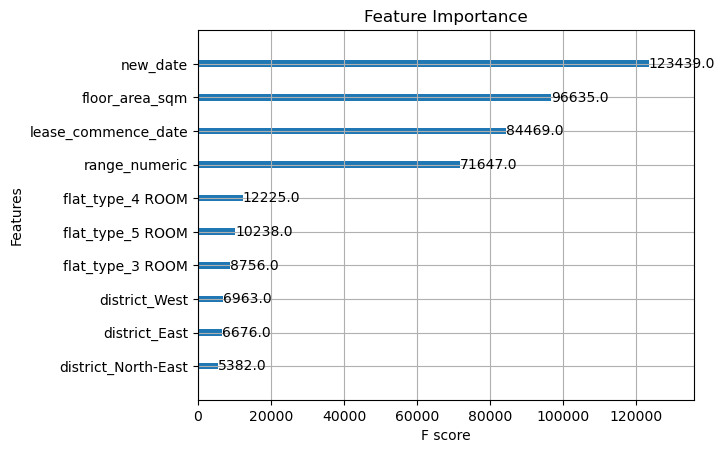

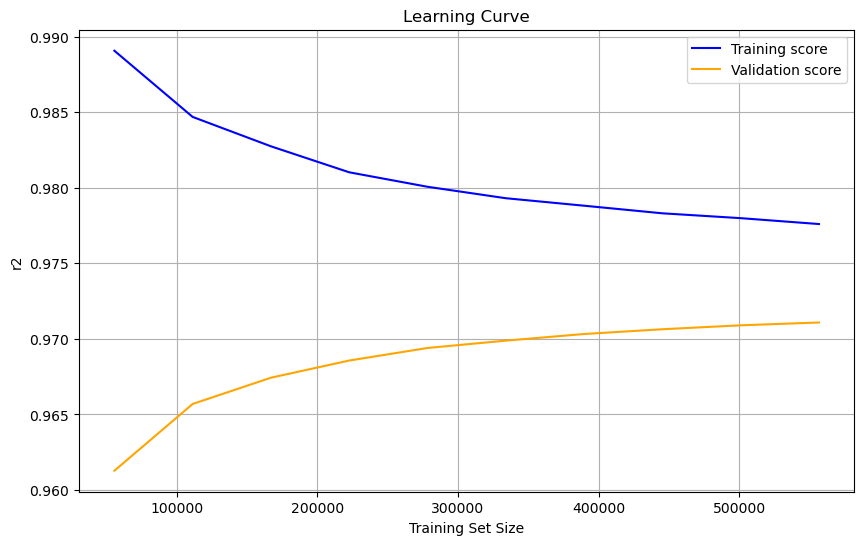

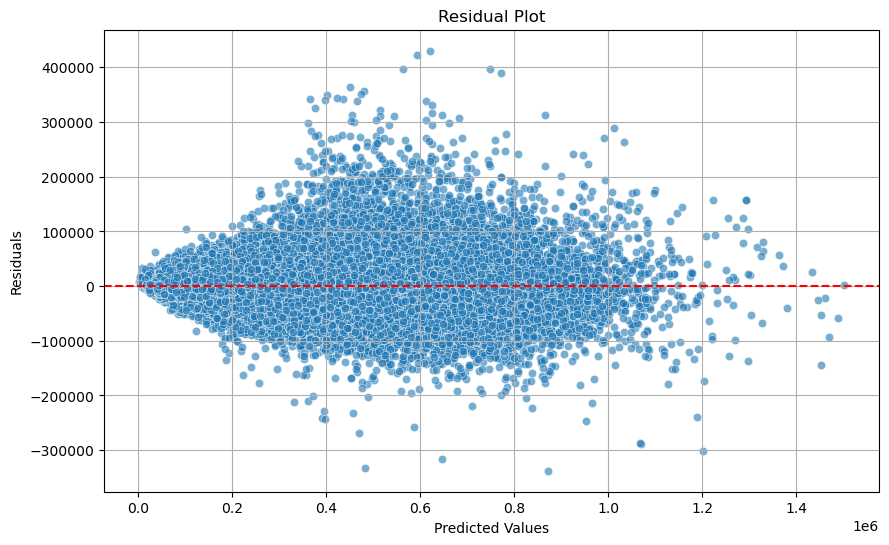

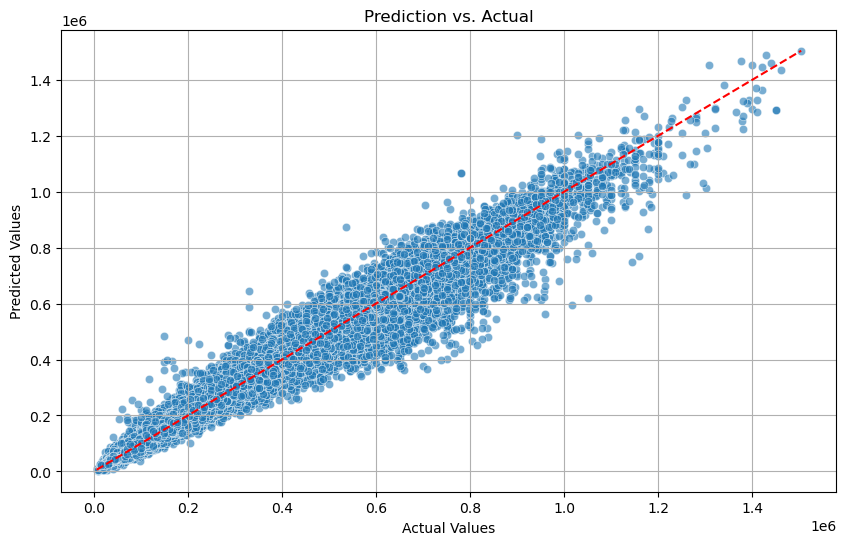

c:\Users\firas\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.



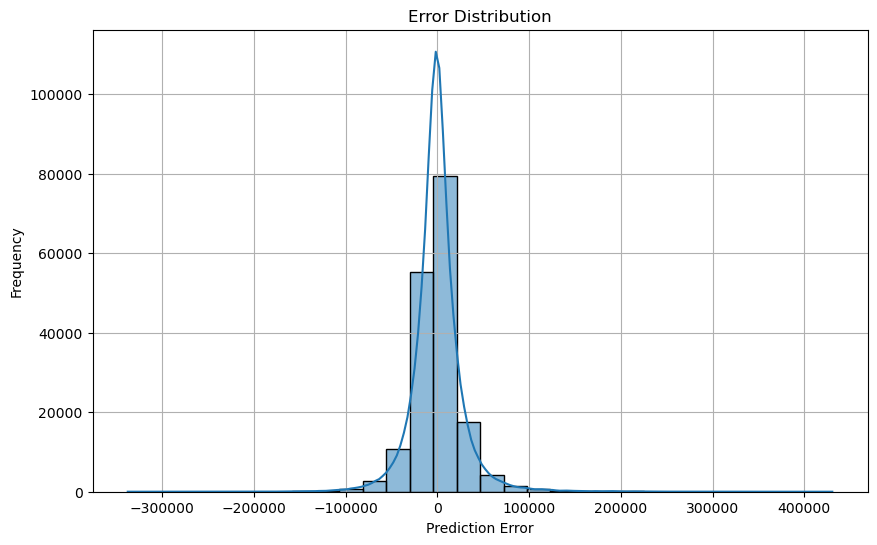

In [34]:


# Plot Learning Curve
def plot_learning_curve(estimator, X, y, cv, scoring, train_sizes=np.linspace(0.1, 1.0, 10)):
    train_sizes, train_scores, valid_scores = learning_curve(
        estimator, X, y, cv=cv, scoring=scoring, train_sizes=train_sizes, n_jobs=-1
    )
    train_mean = np.mean(train_scores, axis=1)
    valid_mean = np.mean(valid_scores, axis=1)

    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes, train_mean, label="Training score", color="blue")
    plt.plot(train_sizes, valid_mean, label="Validation score", color="orange")
    plt.title("Learning Curve")
    plt.xlabel("Training Set Size")
    plt.ylabel(scoring)
    plt.legend(loc="best")
    plt.grid()
    plt.show()

# Residual Plot
def plot_residuals(y_true, y_pred):
    residuals = y_true - y_pred
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=y_pred, y=residuals, alpha=0.6)
    plt.axhline(0, color='red', linestyle='--')
    plt.title("Residual Plot")
    plt.xlabel("Predicted Values")
    plt.ylabel("Residuals")
    plt.grid()
    plt.show()

# Prediction vs. Actual Plot
def plot_predictions(y_true, y_pred):
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=y_true, y=y_pred, alpha=0.6)
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], color='red', linestyle='--')
    plt.title("Prediction vs. Actual")
    plt.xlabel("Actual Values")
    plt.ylabel("Predicted Values")
    plt.grid()
    plt.show()

# Error Distribution Plot
def plot_error_distribution(y_true, y_pred):
    errors = y_true - y_pred
    plt.figure(figsize=(10, 6))
    sns.histplot(errors, bins=30, kde=True)
    plt.title("Error Distribution")
    plt.xlabel("Prediction Error")
    plt.ylabel("Frequency")
    plt.grid()
    plt.show()

# Perform K-Fold Cross-Validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(final_model_v2, X_train, y_train, cv=kf, scoring='r2', n_jobs=-1)
print(f"Cross-Validation R^2 Scores: {scores}")
print(f"Mean R^2: {np.mean(scores):.4f}, Std: {np.std(scores):.4f}")

# Fit model on full training data and evaluate on test set
final_model_v2.fit(X_train, y_train)
y_pred = final_model_v2.predict(X_test)

# Test Metrics
print(f"Test MSE: {mean_squared_error(y_test, y_pred):.4f}")
print(f"Test MAE: {mean_absolute_error(y_test, y_pred):.4f}")
print(f"Test R^2: {r2_score(y_test, y_pred):.4f}")
print(f"Explained Variance: {explained_variance_score(y_test, y_pred):.4f}")
print(f"Mean Absolute Percentage Error (MAPE): {mean_absolute_percentage_error(y_test, y_pred):.4f}")

# Plot Feature Importance
plot_importance(final_model_v2, importance_type='weight', max_num_features=10, title="Feature Importance")
plt.show()

# Plot Graphs
plot_learning_curve(final_model_v2, X_train, y_train, cv=kf, scoring='r2')
plot_residuals(y_test, y_pred)
plot_predictions(y_test, y_pred)
plot_error_distribution(y_test, y_pred)


In [ ]:
y_pred = final_model_v2.predict(X_test)

# Metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Create the scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.7, color='blue', label='Predictions')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label='Ideal Fit')


# Add labels, title, and legend
plt.xlabel("Actual Prices")
plt.ylabel("Predicted Prices")
plt.title("Predicted Prices vs Actual Prices")
plt.legend()
plt.grid(alpha=0.3)

# Display the metrics on the plot
metrics_text = f"MAE: {mae:.2f}\nMSE: {mse:.2f}\nR²: {r2:.4f}"
plt.gca().text(0.75, 0.15, metrics_text, transform=plt.gca().transAxes, fontsize=12, verticalalignment='top',
               bbox=dict(boxstyle="round", alpha=0.5, color="lightblue"))
# Display the plot
plt.show()


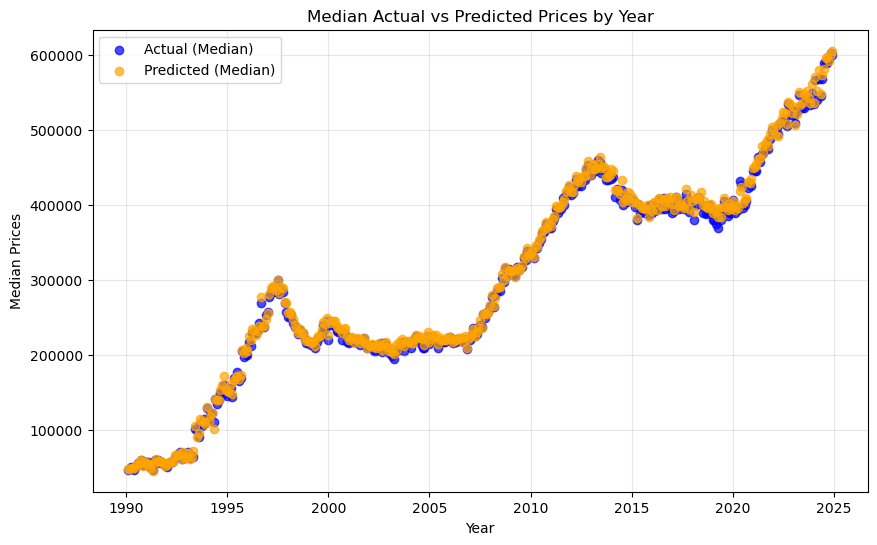

In [35]:

# Create a DataFrame to hold predictions and actual values
results_df = pd.DataFrame({
    'year': X_test['new_date'],
    'y_test': y_test,
    'xgb_pred': y_pred
})

# Group by year and calculate median
median_results = results_df.groupby('year').median().reset_index()

# Scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(median_results['year'], median_results['y_test'], color='blue', label='Actual (Median)', alpha=0.7)
plt.scatter(median_results['year'], median_results['xgb_pred'], color='orange', label='Predicted (Median)', alpha=0.7)

# Add labels, title, and legend
plt.xlabel("Year")
plt.ylabel("Median Prices")
plt.title("Median Actual vs Predicted Prices by Year")
plt.legend()
plt.grid(alpha=0.3)

# Show the plot
plt.show()

In [36]:
joblib.dump(final_model_v2,'new_model_v1.pkl')

['new_model_v1.pkl']

Random Forest MSE: 1037976499.05, R²: 0.96
XGBoost MSE: 937943215.92, R²: 0.97
Ensemble MSE: 925207277.16, R²: 0.97


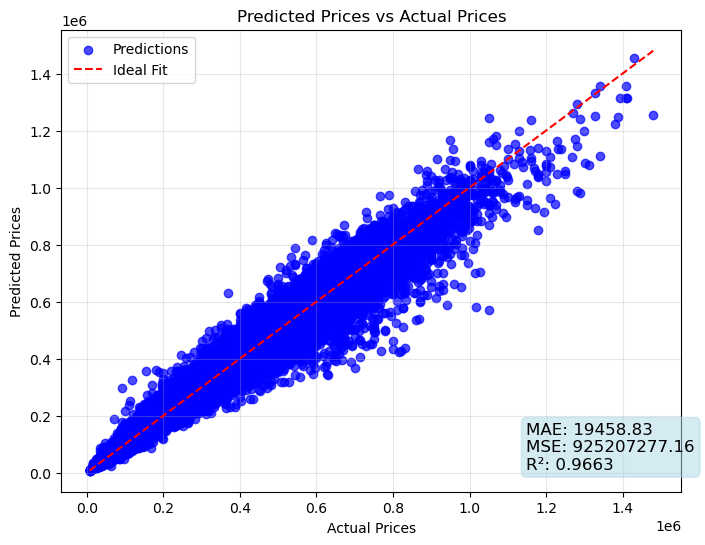

In [ ]:
# Predictions
y_pred_rf = rf_model.predict(X_test)
y_pred_xgb = xgb_model.predict(X_test)

# Evaluate Models
rf_mae = mean_absolute_error(y_test, y_pred_rf)
xgb_mae = mean_absolute_error(y_test, y_pred_xgb)
rf_mse = mean_squared_error(y_test, y_pred_rf)
xgb_mse = mean_squared_error(y_test, y_pred_xgb)
rf_r2 = r2_score(y_test, y_pred_rf)
xgb_r2 = r2_score(y_test, y_pred_xgb)

print(f"Random Forest MSE: {rf_mse:.2f}, R²: {rf_r2:.2f}")
print(f"XGBoost MSE: {xgb_mse:.2f}, R²: {xgb_r2:.2f}")

# Ensemble (Averaging Predictions)
ensemble_pred = (y_pred_rf + y_pred_xgb) / 2
ensemble_mae = mean_absolute_error(y_test,ensemble_pred)
ensemble_mse = mean_squared_error(y_test, ensemble_pred)
ensemble_r2 = r2_score(y_test, ensemble_pred)

print(f"Ensemble MSE: {ensemble_mse:.2f}, R²: {ensemble_r2:.2f}")

# Create the scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(y_test, ensemble_pred, alpha=0.7, color='blue', label='Predictions')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label='Ideal Fit')


# Add labels, title, and legend
plt.xlabel("Actual Prices")
plt.ylabel("Predicted Prices")
plt.title("Predicted Prices vs Actual Prices")
plt.legend()
plt.grid(alpha=0.3)

# Display the metrics on the plot
metrics_text = f"MAE: {ensemble_mae:.2f}\nMSE: {ensemble_mse:.2f}\nR²: {ensemble_r2:.4f}"
plt.gca().text(0.75, 0.15, metrics_text, transform=plt.gca().transAxes, fontsize=12, verticalalignment='top',
               bbox=dict(boxstyle="round", alpha=0.5, color="lightblue"))
# Display the plot
plt.show()





In [ ]:
from sklearn.metrics import mean_squared_error

train_losses = []
val_losses = []

for train_size in train_sizes:
    X_partial = X_train[:train_size]
    y_partial = y_train[:train_size]
    
    model = RandomForestRegressor(random_state=42)
    model.fit(X_partial, y_partial)
    
    # Training Loss
    train_pred = model.predict(X_partial)
    train_loss = mean_squared_error(y_partial, train_pred)
    train_losses.append(train_loss)
    
    # Validation Loss
    val_pred = model.predict(X_test)
    val_loss = mean_squared_error(y_test, val_pred)
    val_losses.append(val_loss)


In [19]:
import xgboost as xgb

# Define the model with early stopping and loss tracking
model = xgb.XGBRegressor(objective='reg:squarederror', eval_metric='rmse', random_state=42)

eval_set = [(X_train, y_train), (X_test, y_test)]
model.fit(X_train, y_train, eval_set=eval_set, verbose=True)

# Extract training and validation loss
results = model.evals_result()
train_loss = results['validation_0']['rmse']
val_loss = results['validation_1']['rmse']


[0]	validation_0-rmse:125611.62118	validation_1-rmse:125289.30973
[1]	validation_0-rmse:98553.60555	validation_1-rmse:98249.13385
[2]	validation_0-rmse:80570.44763	validation_1-rmse:80362.35759
[3]	validation_0-rmse:69467.05530	validation_1-rmse:69324.77475
[4]	validation_0-rmse:61325.88421	validation_1-rmse:61225.07813
[5]	validation_0-rmse:56488.72109	validation_1-rmse:56445.39425
[6]	validation_0-rmse:52264.89560	validation_1-rmse:52301.79123
[7]	validation_0-rmse:50154.73763	validation_1-rmse:50256.89439
[8]	validation_0-rmse:47071.30442	validation_1-rmse:47288.19080
[9]	validation_0-rmse:45438.40044	validation_1-rmse:45741.26119
[10]	validation_0-rmse:43544.53872	validation_1-rmse:43942.07068
[11]	validation_0-rmse:42520.61313	validation_1-rmse:42961.48343
[12]	validation_0-rmse:41011.04519	validation_1-rmse:41506.26356
[13]	validation_0-rmse:40513.48087	validation_1-rmse:41054.41125
[14]	validation_0-rmse:39964.21276	validation_1-rmse:40558.86071
[15]	validation_0-rmse:39474.2127

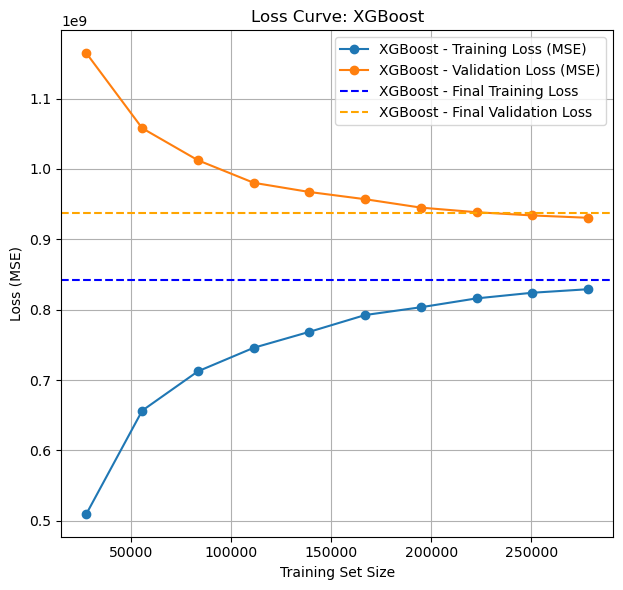

In [22]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split


# Initialize models
rf_model = RandomForestRegressor(random_state=42)
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)

# Define a function to compute and plot learning curves along with loss curves
def plot_learning_and_loss_curve(model, model_name, X, y, X_val, y_val):
    train_sizes, train_scores, val_scores = learning_curve(
        model, X, y, cv=5, scoring='neg_mean_squared_error',
        train_sizes=np.linspace(0.1, 1.0, 10), n_jobs=-1)
    
    # Convert negative MSE to positive
    train_losses = -train_scores.mean(axis=1)
    val_losses = -val_scores.mean(axis=1)
    
    # Train the model on the full training set for loss tracking
    model.fit(X, y)
    
    # Compute loss on full training and validation sets
    y_train_pred = model.predict(X)
    y_val_pred = model.predict(X_val)
    train_loss = mean_squared_error(y, y_train_pred)
    val_loss = mean_squared_error(y_val, y_val_pred)
    
    # Plot the learning curve
    plt.plot(train_sizes, train_losses, label=f'{model_name} - Training Loss (MSE)', marker='o')
    plt.plot(train_sizes, val_losses, label=f'{model_name} - Validation Loss (MSE)', marker='o')
    plt.axhline(y=train_loss, color='blue', linestyle='--', label=f'{model_name} - Final Training Loss')
    plt.axhline(y=val_loss, color='orange', linestyle='--', label=f'{model_name} - Final Validation Loss')
    plt.xlabel('Training Set Size')
    plt.ylabel('Loss (MSE)')
    plt.title(f'Loss Curve: {model_name}')
    plt.legend()
    plt.grid(True)

# Plot learning and loss curves for Random Forest
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plot_learning_and_loss_curve(rf_model, 'Random Forest', X_train, y_train, X_test, y_test)

# Plot learning and loss curves for XGBoost
plt.subplot(1, 2, 2)
plot_learning_and_loss_curve(xgb_model, 'XGBoost', X_train, y_train, X_test, y_test)

plt.tight_layout()
plt.show()


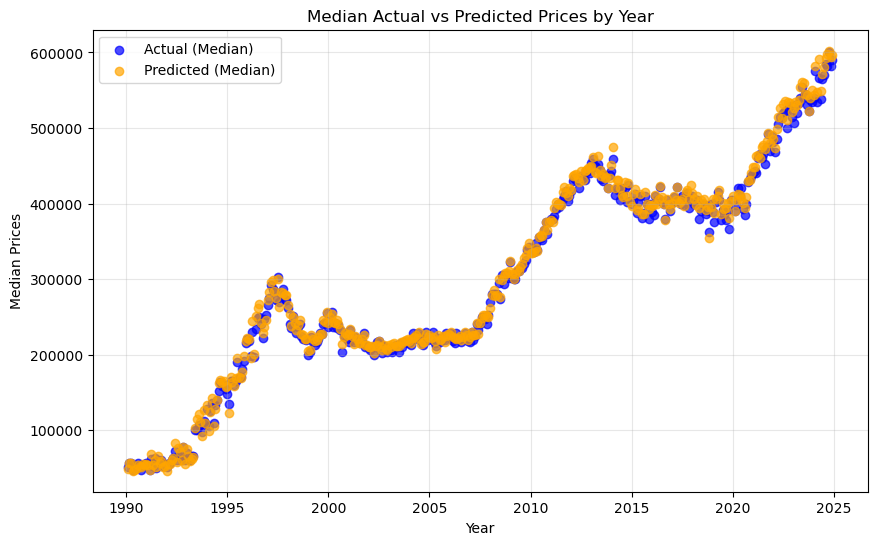

In [18]:

# Create a DataFrame to hold predictions and actual values
results_df = pd.DataFrame({
    'year': X_test['new_date'],
    'y_test': y_test,
    'xgb_pred': y_pred_rf
})

# Group by year and calculate median
median_results = results_df.groupby('year').median().reset_index()

# Scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(median_results['year'], median_results['y_test'], color='blue', label='Actual (Median)', alpha=0.7)
plt.scatter(median_results['year'], median_results['xgb_pred'], color='orange', label='Predicted (Median)', alpha=0.7)

# Add labels, title, and legend
plt.xlabel("Year")
plt.ylabel("Median Prices")
plt.title("Median Actual vs Predicted Prices by Year")
plt.legend()
plt.grid(alpha=0.3)

# Show the plot
plt.show()

In [9]:
xgb_model = XGBRegressor(random_state = 42, n_estimators = 500)
xgb_model.fit(X_train,y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=500, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

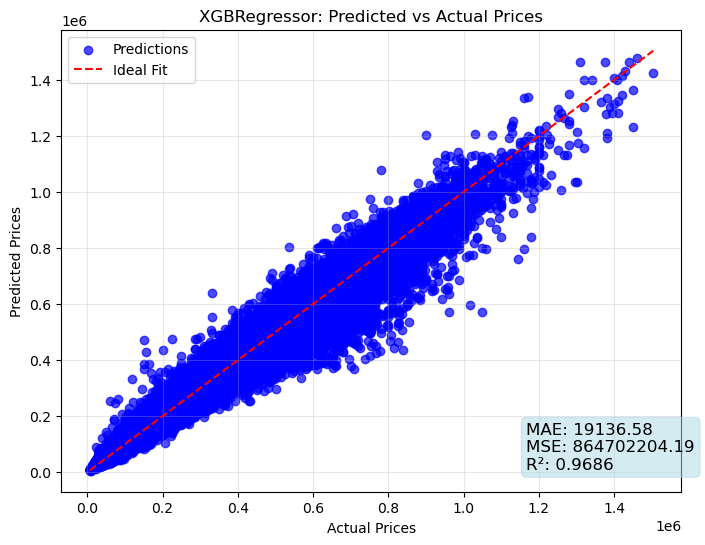

In [10]:


# Predictions and metrics
y_pred_lgb = xgb_model.predict(X_test)
mae_lgb = mean_absolute_error(y_test, y_pred_lgb)
mse_lgb = mean_squared_error(y_test, y_pred_lgb)
r2_lgb = r2_score(y_test, y_pred_lgb)

# Plot
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_lgb, alpha=0.7, color='blue', label='Predictions')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label='Ideal Fit')
plt.xlabel("Actual Prices")
plt.ylabel("Predicted Prices")
plt.title("XGBRegressor: Predicted vs Actual Prices")
plt.legend()
plt.grid(alpha=0.3)
metrics_text = f"MAE: {mae_lgb:.2f}\nMSE: {mse_lgb:.2f}\nR²: {r2_lgb:.4f}"
plt.gca().text(0.75, 0.15, metrics_text, transform=plt.gca().transAxes, fontsize=12, verticalalignment='top',
               bbox=dict(boxstyle="round", alpha=0.5, color="lightblue"))
plt.show()

In [47]:
# Initialize and fit the LightGBM model
lgb_model = lgb.LGBMRegressor()
lgb_model.fit(X_train, y_train)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004926 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 479
[LightGBM] [Info] Number of data points in the train set: 695716, number of used features: 12
[LightGBM] [Info] Start training from score 309504.113280


LGBMRegressor()

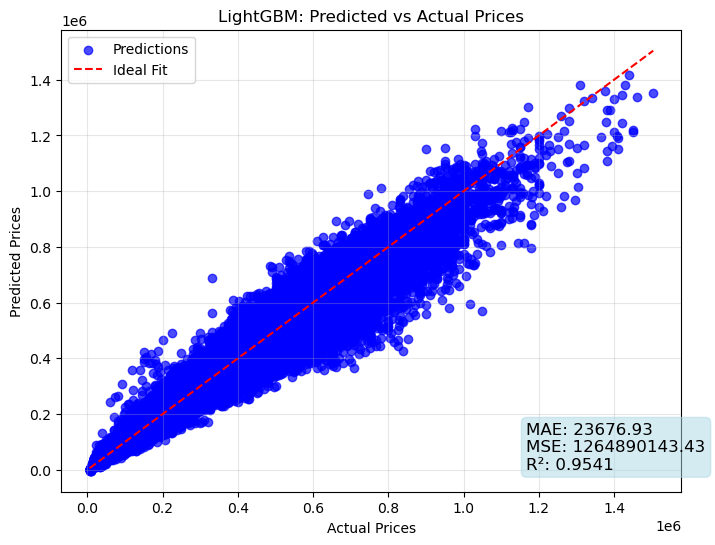

In [48]:


# Predictions and metrics
y_pred_lgb = lgb_model.predict(X_test)
mae_lgb = mean_absolute_error(y_test, y_pred_lgb)
mse_lgb = mean_squared_error(y_test, y_pred_lgb)
r2_lgb = r2_score(y_test, y_pred_lgb)

# Plot
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_lgb, alpha=0.7, color='blue', label='Predictions')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label='Ideal Fit')
plt.xlabel("Actual Prices")
plt.ylabel("Predicted Prices")
plt.title("LightGBM: Predicted vs Actual Prices")
plt.legend()
plt.grid(alpha=0.3)
metrics_text = f"MAE: {mae_lgb:.2f}\nMSE: {mse_lgb:.2f}\nR²: {r2_lgb:.4f}"
plt.gca().text(0.75, 0.15, metrics_text, transform=plt.gca().transAxes, fontsize=12, verticalalignment='top',
               bbox=dict(boxstyle="round", alpha=0.5, color="lightblue"))
plt.show()

In [49]:
# Initialize and fit the CatBoost model
cat_model = CatBoostRegressor(verbose=0)
cat_model.fit(X_train, y_train)

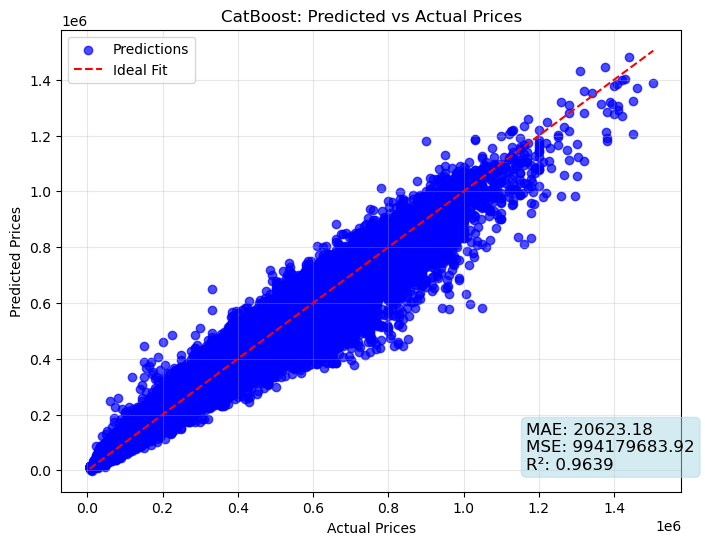

In [50]:
# Predictions and metrics
y_pred_cat = cat_model.predict(X_test)
mae_cat = mean_absolute_error(y_test, y_pred_cat)
mse_cat = mean_squared_error(y_test, y_pred_cat)
r2_cat = r2_score(y_test, y_pred_cat)

# Plot
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_cat, alpha=0.7, color='blue', label='Predictions')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label='Ideal Fit')
plt.xlabel("Actual Prices")
plt.ylabel("Predicted Prices")
plt.title("CatBoost: Predicted vs Actual Prices")
plt.legend()
plt.grid(alpha=0.3)
metrics_text = f"MAE: {mae_cat:.2f}\nMSE: {mse_cat:.2f}\nR²: {r2_cat:.4f}"
plt.gca().text(0.75, 0.15, metrics_text, transform=plt.gca().transAxes, fontsize=12, verticalalignment='top',
               bbox=dict(boxstyle="round", alpha=0.5, color="lightblue"))
plt.show()

In [52]:
rf_model = RandomForestRegressor(n_estimators= 100, random_state=42)
rf_model.fit(X_train,y_train)

RandomForestRegressor(random_state=42)

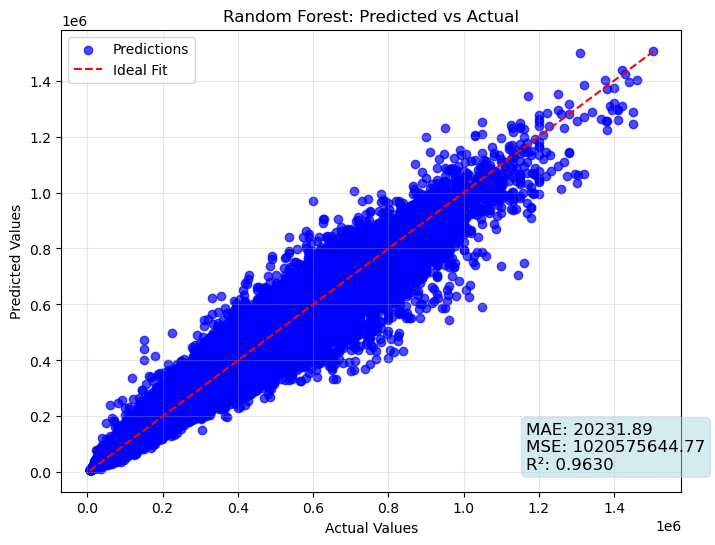

In [53]:
# Predictions and metrics
y_pred_rf = rf_model.predict(X_test)
mae_rf = mean_absolute_error(y_test, y_pred_rf)
mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

# Plot
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_rf, alpha=0.7, color='blue', label='Predictions')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label='Ideal Fit')
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Random Forest: Predicted vs Actual")
plt.legend()
plt.grid(alpha=0.3)

# Display the metrics on the plot
metrics_text = f"MAE: {mae_rf:.2f}\nMSE: {mse_rf:.2f}\nR²: {r2_rf:.4f}"
plt.gca().text(0.75, 0.15, metrics_text, transform=plt.gca().transAxes, fontsize=12, verticalalignment='top',
               bbox=dict(boxstyle="round", alpha=0.5, color="lightblue"))
plt.show()

In [23]:

lin_model = LinearRegression()
lin_model.fit(X_train, y_train)

LinearRegression()

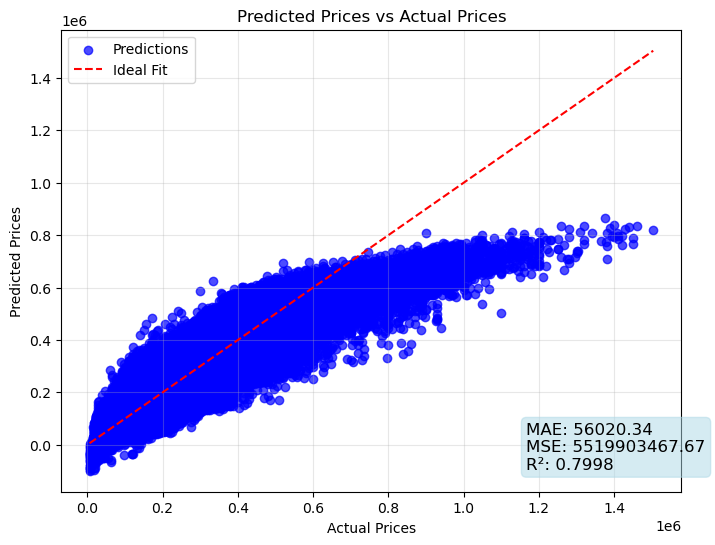

In [24]:
y_pred = lin_model.predict(X_test)

# Metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Create the scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.7, color='blue', label='Predictions')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label='Ideal Fit')


# Add labels, title, and legend
plt.xlabel("Actual Prices")
plt.ylabel("Predicted Prices")
plt.title("Predicted Prices vs Actual Prices")
plt.legend()
plt.grid(alpha=0.3)

# Display the metrics on the plot
metrics_text = f"MAE: {mae:.2f}\nMSE: {mse:.2f}\nR²: {r2:.4f}"
plt.gca().text(0.75, 0.15, metrics_text, transform=plt.gca().transAxes, fontsize=12, verticalalignment='top',
               bbox=dict(boxstyle="round", alpha=0.5, color="lightblue"))
# Display the plot
plt.show()

In [27]:
poly_model = make_pipeline(PolynomialFeatures(degree=2), LinearRegression())
poly_model.fit(X_train, y_train)


Pipeline(steps=[('polynomialfeatures', PolynomialFeatures()),
                ('linearregression', LinearRegression())])

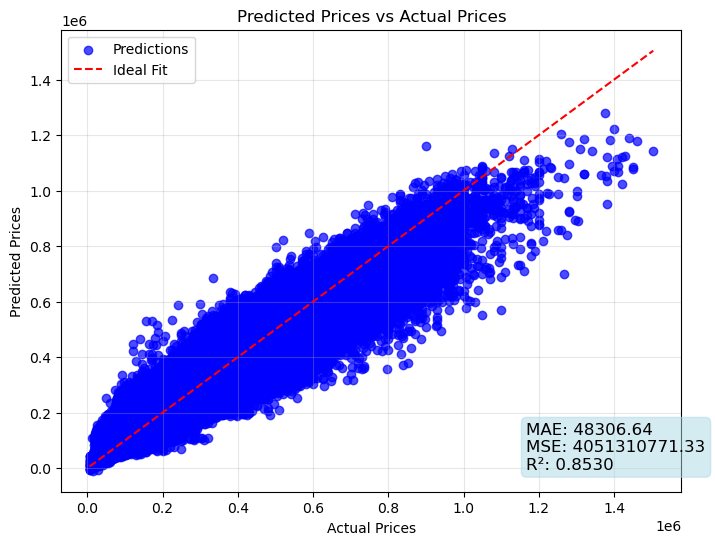

In [28]:
y_pred = poly_model.predict(X_test)

# Metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Create the scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.7, color='blue', label='Predictions')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label='Ideal Fit')


# Add labels, title, and legend
plt.xlabel("Actual Prices")
plt.ylabel("Predicted Prices")
plt.title("Predicted Prices vs Actual Prices")
plt.legend()
plt.grid(alpha=0.3)

# Display the metrics on the plot
metrics_text = f"MAE: {mae:.2f}\nMSE: {mse:.2f}\nR²: {r2:.4f}"
plt.gca().text(0.75, 0.15, metrics_text, transform=plt.gca().transAxes, fontsize=12, verticalalignment='top',
               bbox=dict(boxstyle="round", alpha=0.5, color="lightblue"))
# Display the plot
plt.show()

c:\Users\firas\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\firas\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\firas\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\firas\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\firas\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next versio

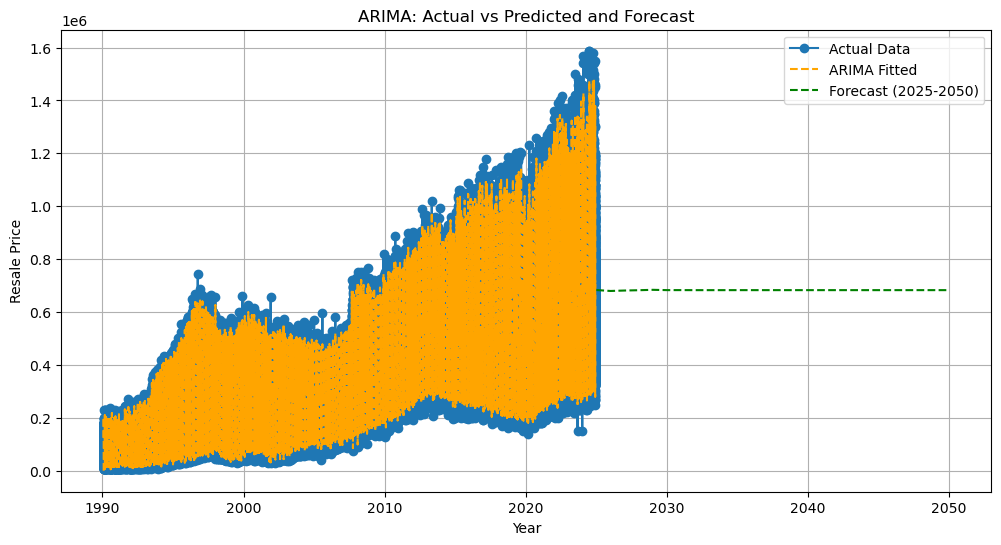

(3348885939.132387, 27700.24892551467, 0.8788192370629987)

In [30]:

# Assuming 'resale_price' is indexed by 'new_date'
time_series_data = data[['new_date', 'resale_price']].set_index('new_date')

# Fit ARIMA model
model = ARIMA(time_series_data, order=(5, 1, 0))
arima_fit = model.fit()

# Forecast future values (2024 to 2050)
future_forecast = arima_fit.forecast(steps=26)
forecast_years = np.arange(2025, 2051)

# Combine actual and forecast data for comparison
combined_data = pd.concat([time_series_data, pd.Series(future_forecast, index=forecast_years)])

# Metrics calculation (for training period)
train_actual = time_series_data.values
train_pred = arima_fit.fittedvalues

mse = mean_squared_error(train_actual, train_pred)
mae = mean_absolute_error(train_actual, train_pred)
r2 = r2_score(train_actual, train_pred)

# Plot actual vs predicted
plt.figure(figsize=(12, 6))
plt.plot(time_series_data.index, time_series_data.values, label="Actual Data", marker='o')
plt.plot(time_series_data.index, train_pred, label="ARIMA Fitted", linestyle='--', color='orange')
plt.plot(forecast_years, future_forecast, label="Forecast (2025-2050)", linestyle='--', color='green')
plt.xlabel("Year")
plt.ylabel("Resale Price")
plt.title("ARIMA: Actual vs Predicted and Forecast")
plt.legend()
plt.grid(True)
plt.show()

mse, mae, r2


In [10]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
import optuna
import numpy as np

def objective(trial):
    # Define hyperparameter search space for RandomForestRegressor
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 200),  # Number of trees
        'max_depth': trial.suggest_int('max_depth', 3, 30, log=True),  # Depth of each tree
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),  # Minimum samples to split a node
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 20),    # Minimum samples in each leaf
        'max_features': trial.suggest_float('max_features', 0.1, 1.0),       # Fraction of features to consider
        'bootstrap': trial.suggest_categorical('bootstrap', [True, False]),  # Bootstrap sampling
    }

    # Initialize RandomForestRegressor with current parameters
    model = RandomForestRegressor(**param, random_state=42)

    # Use cross-validation to evaluate the model
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
    rmse = np.sqrt(-scores.mean())  # Convert negative MSE to RMSE
    return rmse

# Run the optimization
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=20)

# Print the best trial
print("Best Trial:", study.best_trial.params)
print("Best RMSE:", study.best_value)


[I 2025-01-07 10:40:39,411] A new study created in memory with name: no-name-11a01c21-565e-498b-bc29-c3dc6e7496be
[I 2025-01-07 10:45:25,796] Trial 0 finished with value: 36541.12190614621 and parameters: {'n_estimators': 140, 'max_depth': 13, 'min_samples_split': 8, 'min_samples_leaf': 16, 'max_features': 0.7716551620304883, 'bootstrap': True}. Best is trial 0 with value: 36541.12190614621.
[I 2025-01-07 10:51:30,786] Trial 1 finished with value: 60471.3594004906 and parameters: {'n_estimators': 151, 'max_depth': 7, 'min_samples_split': 4, 'min_samples_leaf': 6, 'max_features': 0.9286514690332781, 'bootstrap': False}. Best is trial 0 with value: 36541.12190614621.
[I 2025-01-07 10:53:38,123] Trial 2 finished with value: 63034.08366993758 and parameters: {'n_estimators': 191, 'max_depth': 9, 'min_samples_split': 6, 'min_samples_leaf': 10, 'max_features': 0.10850588592337093, 'bootstrap': False}. Best is trial 0 with value: 36541.12190614621.
[I 2025-01-07 10:55:04,884] Trial 3 finished

Best Trial: {'n_estimators': 138, 'max_depth': 22, 'min_samples_split': 12, 'min_samples_leaf': 7, 'max_features': 0.6283551656067656, 'bootstrap': False}
Best RMSE: 30861.940280609644


In [12]:
best_params_rf = study.best_trial.params
model_rf = RandomForestRegressor(**best_params_rf, random_state=42)


In [14]:
model_rf.fit(X_train, y_train)

RandomForestRegressor(bootstrap=False, max_depth=22,
                      max_features=0.6283551656067656, min_samples_leaf=7,
                      min_samples_split=12, n_estimators=138, random_state=42)

In [26]:
# Define the function to plot learning curve
def plot_learning_curve(estimator, X, y, scoring='r2', cv=5, train_sizes=np.linspace(0.1, 1.0, 10)):
    # Compute learning curve
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, scoring=scoring, train_sizes=train_sizes, n_jobs=-1
    )
    
    # Calculate mean and standard deviation for training and test scores
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    # Plot learning curve
    plt.figure(figsize=(10, 6))
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Validation score")
    
    # Add labels and title
    plt.title("Learning Curve")
    plt.xlabel("Training Examples")
    plt.ylabel(scoring)
    plt.legend(loc="best")
    plt.grid(alpha=0.3)
    plt.show()

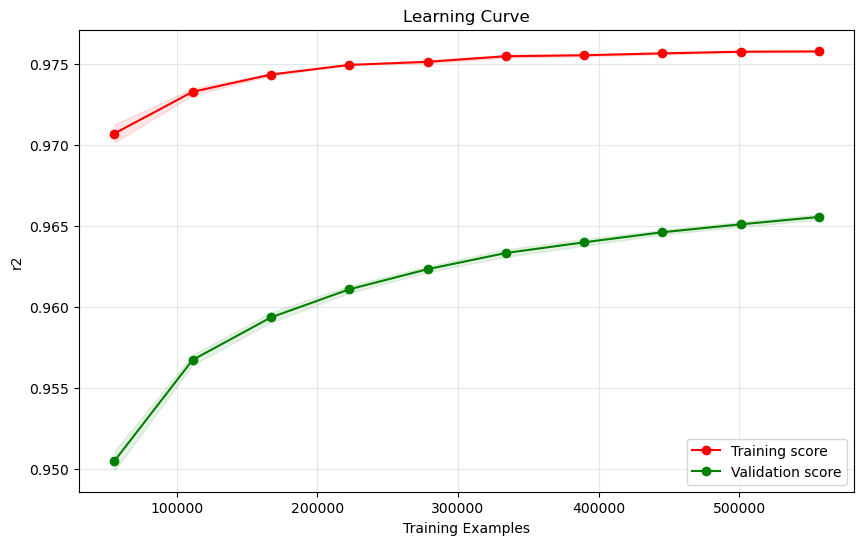

In [27]:
plot_learning_curve(model_rf, X_train, y_train, scoring='r2')

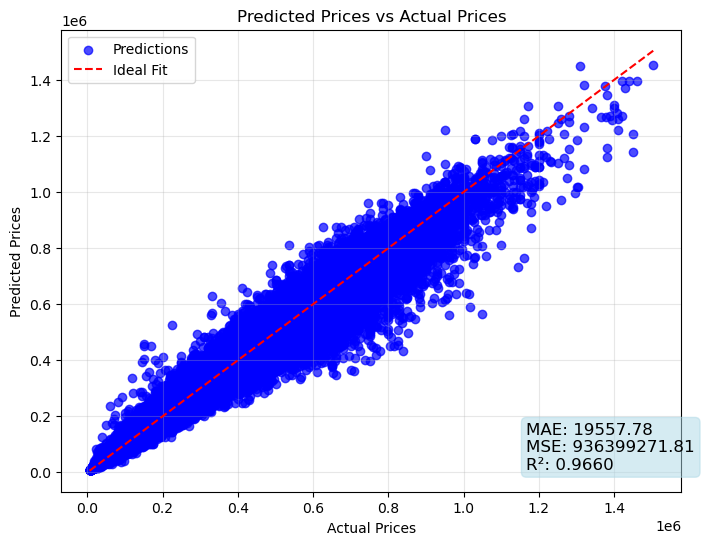

In [15]:
y_pred = model_rf.predict(X_test)

# Metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Create the scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.7, color='blue', label='Predictions')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label='Ideal Fit')


# Add labels, title, and legend
plt.xlabel("Actual Prices")
plt.ylabel("Predicted Prices")
plt.title("Predicted Prices vs Actual Prices")
plt.legend()
plt.grid(alpha=0.3)

# Display the metrics on the plot
metrics_text = f"MAE: {mae:.2f}\nMSE: {mse:.2f}\nR²: {r2:.4f}"
plt.gca().text(0.75, 0.15, metrics_text, transform=plt.gca().transAxes, fontsize=12, verticalalignment='top',
               bbox=dict(boxstyle="round", alpha=0.5, color="lightblue"))
# Display the plot
plt.show()

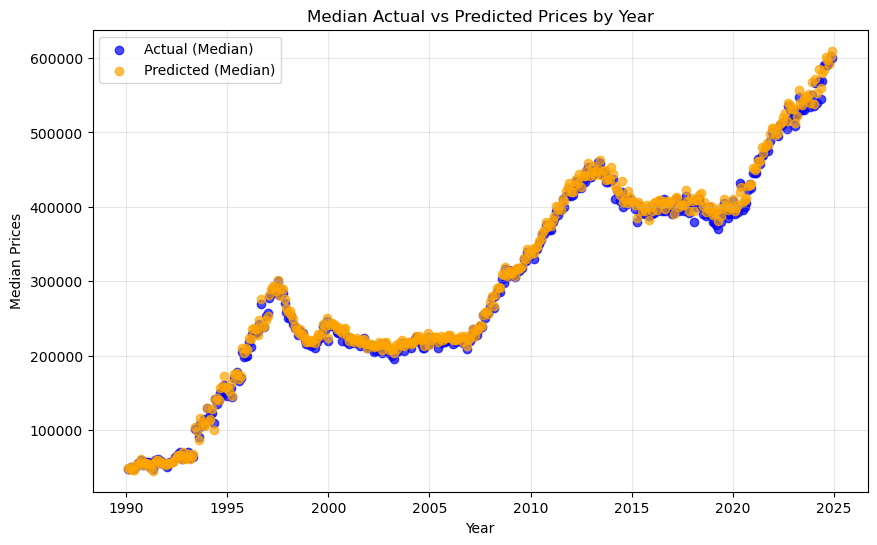

In [17]:

# Create a DataFrame to hold predictions and actual values
results_df = pd.DataFrame({
    'year': X_test['new_date'],
    'y_test': y_test,
    'xgb_pred': y_pred
})

# Group by year and calculate median
median_results = results_df.groupby('year').median().reset_index()

# Scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(median_results['year'], median_results['y_test'], color='blue', label='Actual (Median)', alpha=0.7)
plt.scatter(median_results['year'], median_results['xgb_pred'], color='orange', label='Predicted (Median)', alpha=0.7)

# Add labels, title, and legend
plt.xlabel("Year")
plt.ylabel("Median Prices")
plt.title("Median Actual vs Predicted Prices by Year")
plt.legend()
plt.grid(alpha=0.3)

# Show the plot
plt.show()

Mean Percentage Error: 6.79%
Max Percentage Error: 294.28%
Min Percentage Error: 0.00%


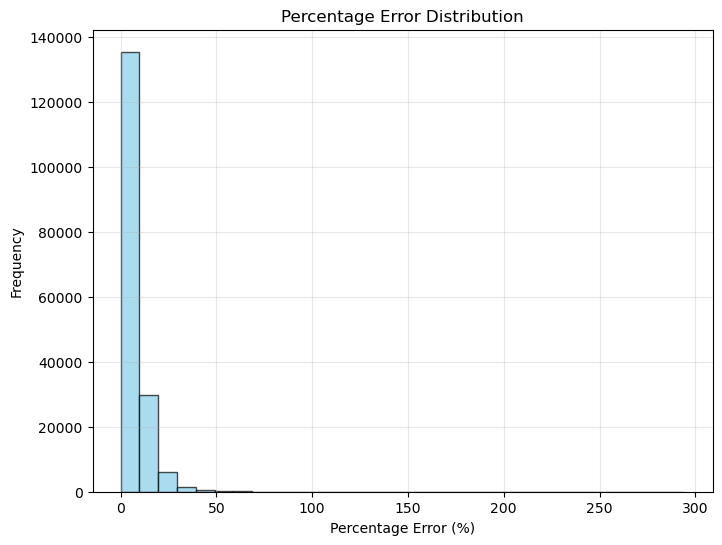

In [39]:
# Calculate the percentage error for each prediction
percentage_error = np.abs((y_test - y_pred) / y) * 100

# Calculate the mean percentage error (optional, for overall performance)
mean_percentage_error = np.mean(percentage_error)

# Display some statistics
print(f"Mean Percentage Error: {mean_percentage_error:.2f}%")
print(f"Max Percentage Error: {np.max(percentage_error):.2f}%")
print(f"Min Percentage Error: {np.min(percentage_error):.2f}%")

# Plot percentage error distribution
plt.figure(figsize=(8, 6))
plt.hist(percentage_error, bins=30, color='skyblue', edgecolor='black', alpha=0.7)
plt.title("Percentage Error Distribution")
plt.xlabel("Percentage Error (%)")
plt.ylabel("Frequency")
plt.grid(alpha=0.3)
plt.show()


In [19]:
joblib.dump(model_rf,'new_model_rf.pkl')

['new_model_rf.pkl']

In [20]:
rf_model = joblib.load('new_model_rf.pkl')
xgb_model = joblib.load('new_model_v1.pkl')

In [30]:
# Predictions
y_pred_rf = rf_model.predict(X)
y_pred_xgb = xgb_model.predict(X)

# Evaluate Models
rf_mae = mean_absolute_error(y, y_pred_rf)
xgb_mae = mean_absolute_error(y, y_pred_xgb)
rf_mse = mean_squared_error(y, y_pred_rf)
xgb_mse = mean_squared_error(y, y_pred_xgb)
rf_r2 = r2_score(y, y_pred_rf)
xgb_r2 = r2_score(y, y_pred_xgb)

print(f"Random Forest MSE: {rf_mse:.2f}, R²: {rf_r2:.2f}")
print(f"XGBoost MSE: {xgb_mse:.2f}, R²: {xgb_r2:.2f}")







Random Forest MSE: 721040664.55, R²: 0.97
XGBoost MSE: 667559400.13, R²: 0.98


In [33]:
# Define the function to calculate the weighted ensemble predictions
def optimize_ensemble_weights(y_true, y_pred_xgb, y_pred_rf, metric='mse'):
    best_score = float('inf')
    best_weights = (0.5, 0.5)  # Initialize with equal weights
    weight_range = np.linspace(0, 1, 101)  # Test weights from 0 to 1 in steps of 0.01
    
    for w_xgb in weight_range:
        w_rf = 1 - w_xgb  # Ensure weights sum to 1
        ensemble_pred = w_xgb * y_pred_xgb + w_rf * y_pred_rf
        
        # Choose the metric to minimize
        if metric == 'mse':
            score = mean_squared_error(y_true, ensemble_pred)
        elif metric == 'mae':
            score = mean_absolute_error(y_true, ensemble_pred)
        else:
            raise ValueError("Metric must be 'mse' or 'mae'")
        
        # Keep track of the best weights and score
        if score < best_score:
            best_score = score
            best_weights = (w_xgb, w_rf)
    
    return best_weights, best_score

In [ ]:
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error

def optimize_ensemble_weights(y_true, y_pred_xgb, y_pred_rf, y_pred_cat, metric='mse'):
    best_score = float('inf')
    best_weights = (1/3, 1/3, 1/3)  # Initialize with equal weights
    weight_range = np.linspace(0, 1, 101)  # Test weights from 0 to 1 in steps of 0.01

    # Iterate over weights for the first model
    for w_xgb in weight_range:
        for w_rf in weight_range:
            w_cat = 1 - w_xgb - w_rf  # Ensure weights sum to 1
            
            # Skip invalid combinations where weights go below 0 or above 1
            if w_cat < 0 or w_cat > 1:
                continue

            # Calculate ensemble predictions
            ensemble_pred = (w_xgb * y_pred_xgb + 
                             w_rf * y_pred_rf + 
                             w_cat * y_pred_cat)
            
            # Choose the metric to minimize
            if metric == 'mse':
                score = mean_squared_error(y_true, ensemble_pred)
            elif metric == 'mae':
                score = mean_absolute_error(y_true, ensemble_pred)
            else:
                raise ValueError("Metric must be 'mse' or 'mae'")

            # Keep track of the best weights and score
            if score < best_score:
                best_score = score
                best_weights = (w_xgb, w_rf, w_cat)

    return best_weights, best_score


In [34]:
# Optimize weights for the ensemble
best_weights, best_score = optimize_ensemble_weights(y, y_pred_xgb, y_pred_rf, metric='mse')
print(f"Best Weights: XGBoost = {best_weights[0]:.2f}, Random Forest = {best_weights[1]:.2f}")
print(f"Best MSE: {best_score:.4f}")


Best Weights: XGBoost = 0.71, Random Forest = 0.29
Best MSE: 656527268.2803


Ensemble MSE: 656527268.28, R²: 0.98


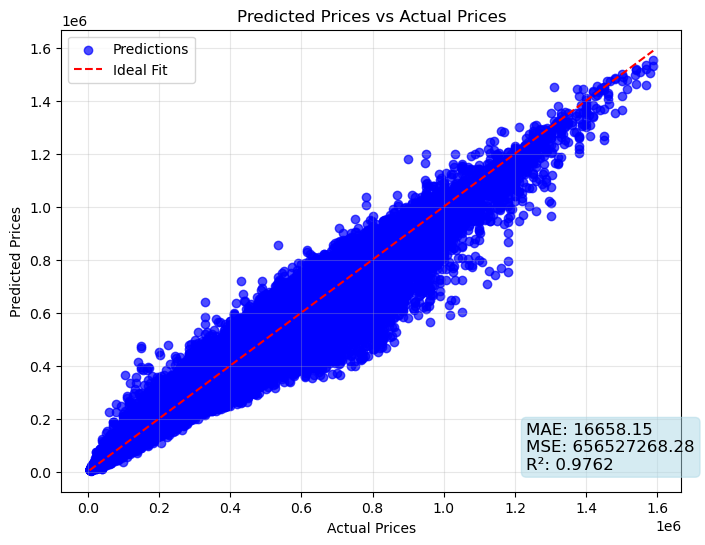

In [35]:
# Ensemble (Averaging Predictions)
ensemble_pred = y_pred_xgb *0.71 + y_pred_rf *0.29
ensemble_mae = mean_absolute_error(y,ensemble_pred)
ensemble_mse = mean_squared_error(y, ensemble_pred)
ensemble_r2 = r2_score(y, ensemble_pred)

print(f"Ensemble MSE: {ensemble_mse:.2f}, R²: {ensemble_r2:.2f}")

# Create the scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(y, ensemble_pred, alpha=0.7, color='blue', label='Predictions')
plt.plot([min(y), max(y)], [min(y), max(y)], color='red', linestyle='--', label='Ideal Fit')


# Add labels, title, and legend
plt.xlabel("Actual Prices")
plt.ylabel("Predicted Prices")
plt.title("Predicted Prices vs Actual Prices")
plt.legend()
plt.grid(alpha=0.3)

# Display the metrics on the plot
metrics_text = f"MAE: {ensemble_mae:.2f}\nMSE: {ensemble_mse:.2f}\nR²: {ensemble_r2:.4f}"
plt.gca().text(0.75, 0.15, metrics_text, transform=plt.gca().transAxes, fontsize=12, verticalalignment='top',
               bbox=dict(boxstyle="round", alpha=0.5, color="lightblue"))
# Display the plot
plt.show()

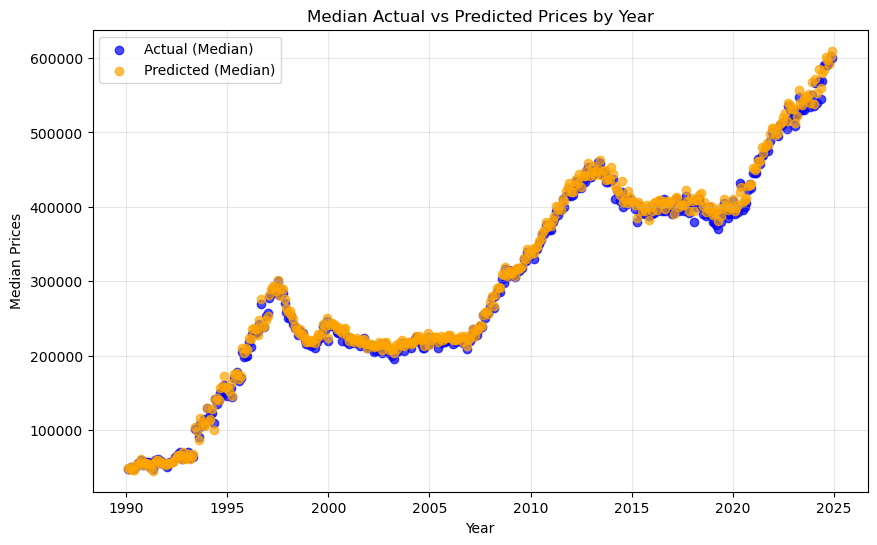

In [ ]:

# Create a DataFrame to hold predictions and actual values
results_df = pd.DataFrame({
    'year': X_test['new_date'],
    'y': y_test,
    'ensemble_pred': ensemble_pred
})

# Group by year and calculate median
median_results = results_df.groupby('year').median().reset_index()

# Scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(median_results['year'], median_results['y'], color='blue', label='Actual (Median)', alpha=0.7)
plt.scatter(median_results['year'], median_results['ensemble_pred'], color='orange', label='Predicted (Median)', alpha=0.7)

# Add labels, title, and legend
plt.xlabel("Year")
plt.ylabel("Median Prices")
plt.title("Median Actual vs Predicted Prices by Year")
plt.legend()
plt.grid(alpha=0.3)

# Show the plot
plt.show()

Mean Percentage Error: 5.96%
Max Percentage Error: 277.68%
Min Percentage Error: 0.00%


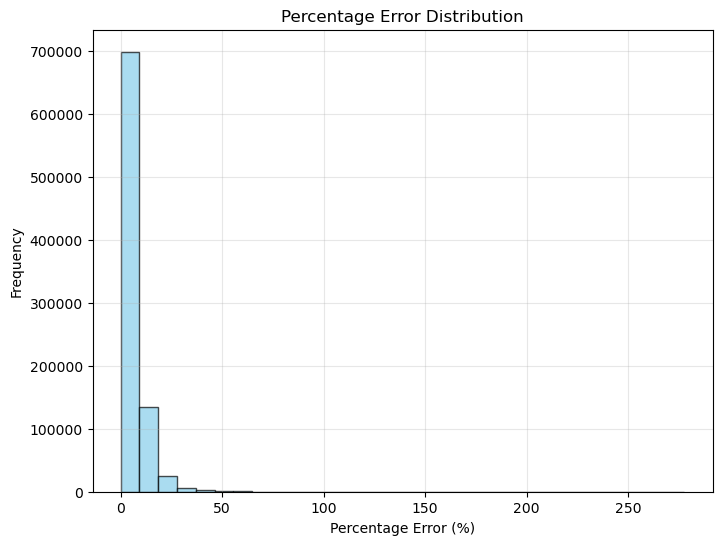

In [38]:
# Calculate the percentage error for each prediction
percentage_error = np.abs((y - ensemble_pred) / y) * 100

# Calculate the mean percentage error (optional, for overall performance)
mean_percentage_error = np.mean(percentage_error)

# Display some statistics
print(f"Mean Percentage Error: {mean_percentage_error:.2f}%")
print(f"Max Percentage Error: {np.max(percentage_error):.2f}%")
print(f"Min Percentage Error: {np.min(percentage_error):.2f}%")

# Plot percentage error distribution
plt.figure(figsize=(8, 6))
plt.hist(percentage_error, bins=30, color='skyblue', edgecolor='black', alpha=0.7)
plt.title("Percentage Error Distribution")
plt.xlabel("Percentage Error (%)")
plt.ylabel("Frequency")
plt.grid(alpha=0.3)
plt.show()


In [11]:

# Define the objective function
def catboost_objective(trial):
    param = {
        'iterations': trial.suggest_int('iterations', 500, 3000),
        'depth': trial.suggest_int('depth', 4, 12),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2, log=True),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-3, 10.0, log=True),
        'bagging_temperature': trial.suggest_float('bagging_temperature', 0.0, 1.0),
        'random_strength': trial.suggest_float('random_strength', 1e-3, 10.0, log=True),
        'border_count': trial.suggest_int('border_count', 32, 255),
        'grow_policy': trial.suggest_categorical('grow_policy', ['SymmetricTree', 'Depthwise', 'Lossguide']),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 1, 30),
        'one_hot_max_size': trial.suggest_int('one_hot_max_size', 2, 10),
        'loss_function': 'RMSE',
        'random_seed': 42
    }

    # Initialize and evaluate the model using cross-validation
    model = CatBoostRegressor(**param, verbose=0)
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
    rmse = np.sqrt(-scores.mean())
    return rmse

# Create the study
catboost_study = optuna.create_study(direction='minimize')
catboost_study.optimize(catboost_objective, n_trials=50)  # Adjust number of trials as needed

# Print the best parameters and RMSE
print("Best Trial:", catboost_study.best_trial.params)
print("Best RMSE:", catboost_study.best_value)


[I 2025-01-07 22:58:24,224] A new study created in memory with name: no-name-4be0baf1-c763-4b00-a952-69c3c18b807b
[I 2025-01-07 23:02:24,880] Trial 0 finished with value: 37413.920796891754 and parameters: {'iterations': 2477, 'depth': 4, 'learning_rate': 0.01777012961311592, 'l2_leaf_reg': 1.4544031106023256, 'bagging_temperature': 0.5783315265045764, 'random_strength': 1.1404026206344768, 'border_count': 55, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 5, 'one_hot_max_size': 5}. Best is trial 0 with value: 37413.920796891754.
[I 2025-01-07 23:06:29,514] Trial 1 finished with value: 37861.94596352051 and parameters: {'iterations': 2540, 'depth': 4, 'learning_rate': 0.014187511611509213, 'l2_leaf_reg': 6.6694931595789475, 'bagging_temperature': 0.010712068170284805, 'random_strength': 1.1030655427290597, 'border_count': 139, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 5, 'one_hot_max_size': 3}. Best is trial 0 with value: 37413.920796891754.
[I 2025-01-07 23:18:03,372] T

Best Trial: {'iterations': 2864, 'depth': 12, 'learning_rate': 0.11684581661338442, 'l2_leaf_reg': 1.8333086448589881, 'bagging_temperature': 0.7349600056058765, 'random_strength': 0.0016994593753810136, 'border_count': 161, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 6, 'one_hot_max_size': 5}
Best RMSE: 28016.27059929441


In [13]:
optuna.visualization.plot_param_importances(catboost_study).show()
optuna.visualization.plot_optimization_history(catboost_study).show()

In [20]:
best_params_cat = catboost_study.best_trial.params
model_cat = CatBoostRegressor(**best_params_cat, random_state=42)


In [21]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import learning_curve, KFold, cross_val_score
from sklearn.metrics import (
    mean_squared_error, mean_absolute_error, r2_score,
    explained_variance_score, mean_absolute_percentage_error
)
from catboost import CatBoostRegressor, Pool, cv

# Plot Learning Curve
def plot_learning_curve(estimator, X, y, cv, scoring, train_sizes=np.linspace(0.1, 1.0, 10)):
    train_sizes, train_scores, valid_scores = learning_curve(
        estimator, X, y, cv=cv, scoring=scoring, train_sizes=train_sizes, n_jobs=-1
    )
    train_mean = np.mean(train_scores, axis=1)
    valid_mean = np.mean(valid_scores, axis=1)

    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes, train_mean, label="Training score", color="blue")
    plt.plot(train_sizes, valid_mean, label="Validation score", color="orange")
    plt.title("Learning Curve")
    plt.xlabel("Training Set Size")
    plt.ylabel(scoring)
    plt.legend(loc="best")
    plt.grid()
    plt.show()

# Residual Plot
def plot_residuals(y_true, y_pred):
    residuals = y_true - y_pred
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=y_pred, y=residuals, alpha=0.6)
    plt.axhline(0, color='red', linestyle='--')
    plt.title("Residual Plot")
    plt.xlabel("Predicted Values")
    plt.ylabel("Residuals")
    plt.grid()
    plt.show()

# Prediction vs. Actual Plot
def plot_predictions(y_true, y_pred):
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=y_true, y=y_pred, alpha=0.6)
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], color='red', linestyle='--')
    plt.title("Prediction vs. Actual")
    plt.xlabel("Actual Values")
    plt.ylabel("Predicted Values")
    plt.grid()
    plt.show()

# Error Distribution Plot
def plot_error_distribution(y_true, y_pred):
    errors = y_true - y_pred
    plt.figure(figsize=(10, 6))
    sns.histplot(errors, bins=30, kde=True)
    plt.title("Error Distribution")
    plt.xlabel("Prediction Error")
    plt.ylabel("Frequency")
    plt.grid()
    plt.show()


# Perform K-Fold Cross-Validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
pool = Pool(X_train, y_train)
cv_results = cv(pool, model_cat.get_params(), fold_count=5, plot=True)

# Train and Evaluate
model_cat.fit(X_train, y_train)
y_pred = model_cat.predict(X_test)

# Test Metrics
print(f"Test MSE: {mean_squared_error(y_test, y_pred):.4f}")
print(f"Test MAE: {mean_absolute_error(y_test, y_pred):.4f}")
print(f"Test R^2: {r2_score(y_test, y_pred):.4f}")
print(f"Explained Variance: {explained_variance_score(y_test, y_pred):.4f}")
print(f"Mean Absolute Percentage Error (MAPE): {mean_absolute_percentage_error(y_test, y_pred):.4f}")





MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]
0:	learn: 311358.5082851	test: 311792.1963524	best: 311792.1963524 (0)	total: 187ms	remaining: 8m 56s
1:	learn: 276215.8971192	test: 276599.2199830	best: 276599.2199830 (1)	total: 269ms	remaining: 6m 24s
2:	learn: 245290.4294752	test: 245624.9240428	best: 245624.9240428 (2)	total: 350ms	remaining: 5m 34s
3:	learn: 218095.7566258	test: 218382.1477772	best: 218382.1477772 (3)	total: 433ms	remaining: 5m 9s
4:	learn: 194257.3426686	test: 194523.5786731	best: 194523.5786731 (4)	total: 514ms	remaining: 4m 53s
5:	learn: 173285.2144793	test: 173518.1874356	best: 173518.1874356 (5)	total: 597ms	remaining: 4m 44s
6:	learn: 154971.1527265	test: 155187.4381355	best: 155187.4381355 (6)	total: 681ms	remaining: 4m 37s
7:	learn: 138916.1842336	test: 139108.9804874	best: 139108.9804874 (7)	total: 762ms	remaining: 4m 31s
8:	learn: 124815.4884494	test: 124983.2560112	best: 124983.2560112 (8)	total: 846ms	remaining: 4m 28s
9:	learn: 112567.1485307	test: 112724.3822752	best: 112724.3

AttributeError: 'CatBoostRegressor' object has no attribute 'plot_importance'

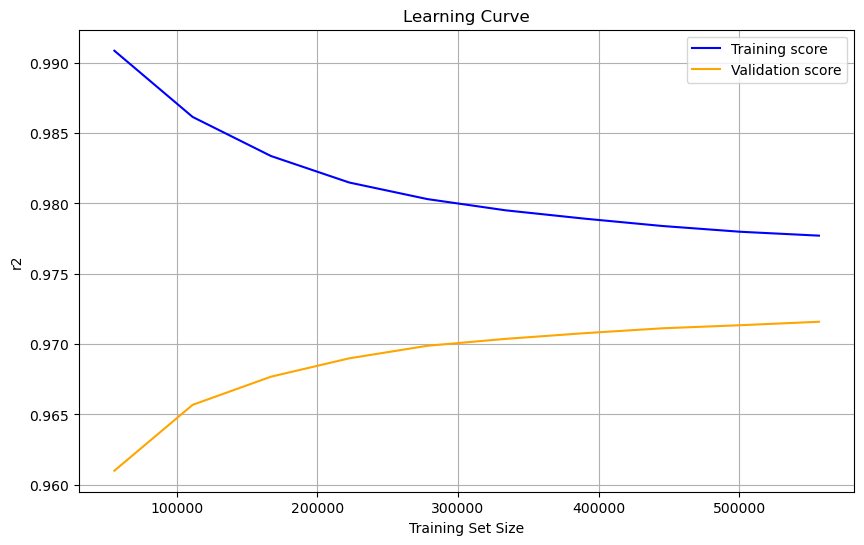

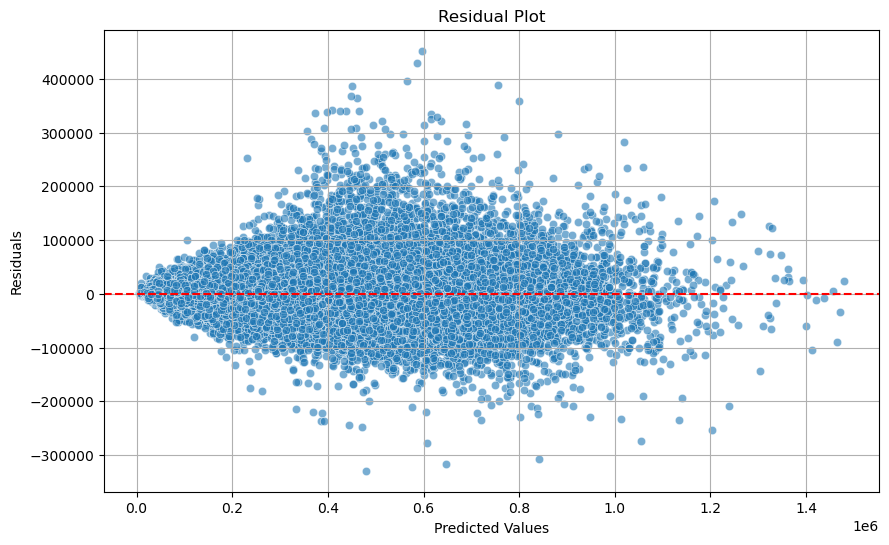

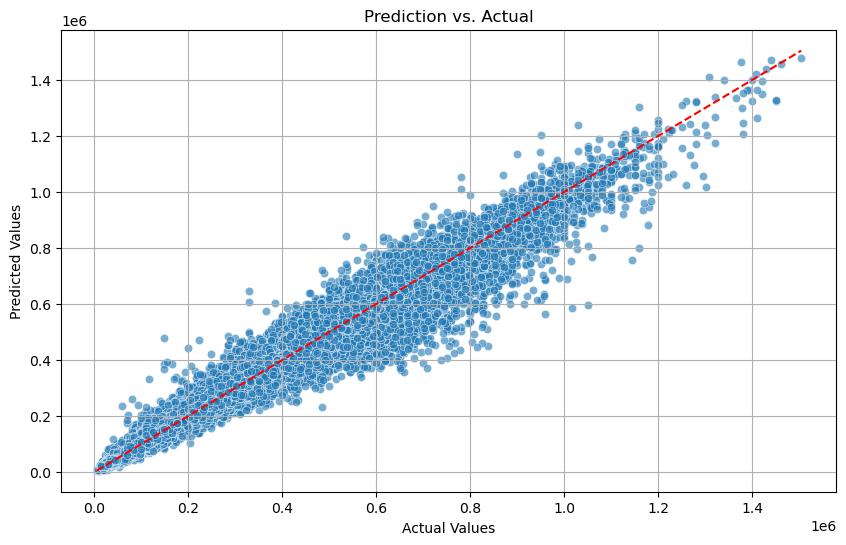

c:\Users\firas\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.



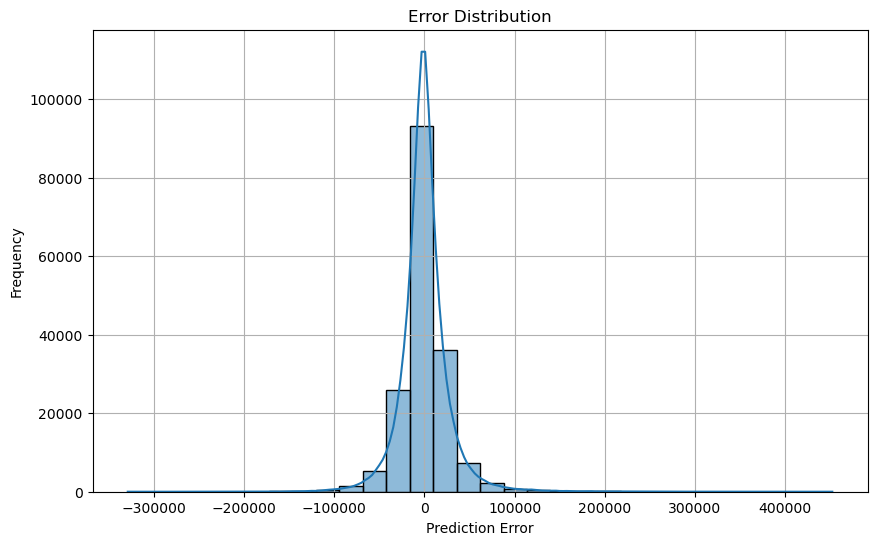

In [22]:
# Plot Graphs
plot_learning_curve(model_cat, X_train, y_train, cv=kf, scoring='r2')
plot_residuals(y_test, y_pred)
plot_predictions(y_test, y_pred)
plot_error_distribution(y_test, y_pred)

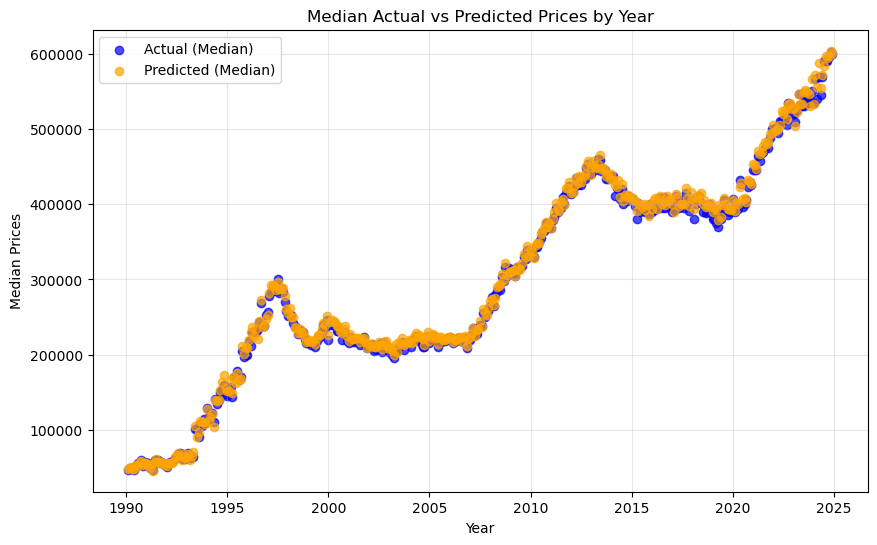

In [23]:

# Create a DataFrame to hold predictions and actual values
results_df = pd.DataFrame({
    'year': X_test['new_date'],
    'y': y_test,
    'cat_pred': y_pred
})

# Group by year and calculate median
median_results = results_df.groupby('year').median().reset_index()

# Scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(median_results['year'], median_results['y'], color='blue', label='Actual (Median)', alpha=0.7)
plt.scatter(median_results['year'], median_results['cat_pred'], color='orange', label='Predicted (Median)', alpha=0.7)

# Add labels, title, and legend
plt.xlabel("Year")
plt.ylabel("Median Prices")
plt.title("Median Actual vs Predicted Prices by Year")
plt.legend()
plt.grid(alpha=0.3)

# Show the plot
plt.show()

In [24]:
joblib.dump(model_cat,'new_model_cat.pkl')

['new_model_cat.pkl']

In [25]:
model_xgb  = joblib.load('new_model_xgb.pkl')
model_rf = joblib.load('new_model_rf.pkl')
model_cat = joblib.load('new_model_cat.pkl')

In [26]:
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error

def optimize_ensemble_weights(y_true, y_pred_xgb, y_pred_rf, y_pred_cat, metric='mse'):
    best_score = float('inf')
    best_weights = (1/3, 1/3, 1/3)  # Initialize with equal weights
    weight_range = np.linspace(0, 1, 101)  # Test weights from 0 to 1 in steps of 0.01

    # Iterate over weights for the first model
    for w_xgb in weight_range:
        for w_rf in weight_range:
            w_cat = 1 - w_xgb - w_rf  # Ensure weights sum to 1
            
            # Skip invalid combinations where weights go below 0 or above 1
            if w_cat < 0 or w_cat > 1:
                continue

            # Calculate ensemble predictions
            ensemble_pred = (w_xgb * y_pred_xgb + 
                             w_rf * y_pred_rf + 
                             w_cat * y_pred_cat)
            
            # Choose the metric to minimize
            if metric == 'mse':
                score = mean_squared_error(y_true, ensemble_pred)
            elif metric == 'mae':
                score = mean_absolute_error(y_true, ensemble_pred)
            else:
                raise ValueError("Metric must be 'mse' or 'mae'")

            # Keep track of the best weights and score
            if score < best_score:
                best_score = score
                best_weights = (w_xgb, w_rf, w_cat)

    return best_weights, best_score


In [27]:
y_pred_rf = model_rf.predict(X)
y_pred_xgb = model_xgb.predict(X)
y_pred_cat = model_cat.predict(X)

# Evaluate Models
rf_mae = mean_absolute_error(y, y_pred_rf)
xgb_mae = mean_absolute_error(y, y_pred_xgb)
cat_mae = mean_absolute_error(y, y_pred_cat)
rf_mse = mean_squared_error(y, y_pred_rf)
xgb_mse = mean_squared_error(y, y_pred_xgb)
cat_mse = mean_squared_error(y, y_pred_cat)
rf_r2 = r2_score(y, y_pred_rf)
xgb_r2 = r2_score(y, y_pred_xgb)
cat_r2 = r2_score(y, y_pred_cat)

print(f"Random Forest MSE: {rf_mse:.2f}, R²: {rf_r2:.2f}")
print(f"XGBoost MSE: {xgb_mse:.2f}, R²: {xgb_r2:.2f}")
print(f"CATBoost MSE: {cat_mse:.2f}, R²: {cat_r2:.2f}")

Random Forest MSE: 721040664.55, R²: 0.97
XGBoost MSE: 667559400.13, R²: 0.98
CATBoost MSE: 663590658.82, R²: 0.98


In [28]:
# Optimize weights for the ensemble
best_weights, best_score = optimize_ensemble_weights(y, y_pred_xgb, y_pred_rf,y_pred_cat, metric='mse')
print(f"Best Weights: XGBoost = {best_weights[0]:.2f}, Random Forest = {best_weights[1]:.2f}, CATBoost = {best_weights[2]:.2f}")
print(f"Best MSE: {best_score:.4f}")

Best Weights: XGBoost = 0.32, Random Forest = 0.23, CATBoost = 0.45
Best MSE: 649584555.0503


Ensemble MSE: 649584555.05, R²: 0.98


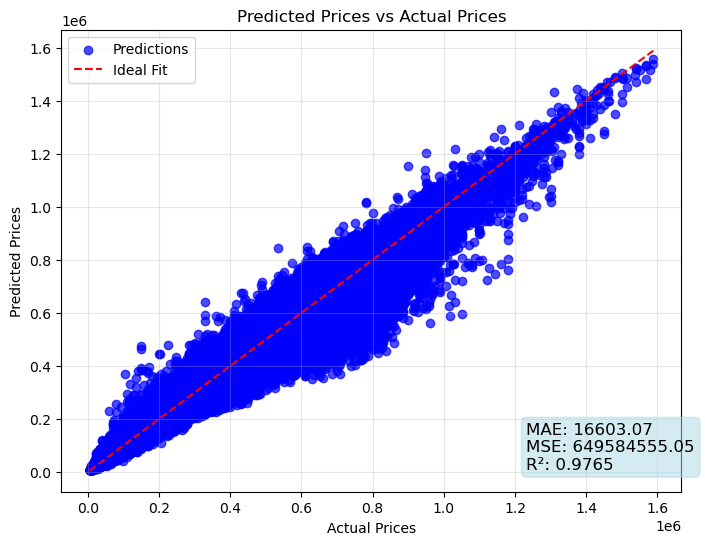

In [29]:
# Ensemble (Averaging Predictions)
ensemble_pred = y_pred_xgb *best_weights[0] + y_pred_rf *best_weights[1] + y_pred_cat*best_weights[2]
ensemble_mae = mean_absolute_error(y,ensemble_pred)
ensemble_mse = mean_squared_error(y, ensemble_pred)
ensemble_r2 = r2_score(y, ensemble_pred)

print(f"Ensemble MSE: {ensemble_mse:.2f}, R²: {ensemble_r2:.2f}")

# Create the scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(y, ensemble_pred, alpha=0.7, color='blue', label='Predictions')
plt.plot([min(y), max(y)], [min(y), max(y)], color='red', linestyle='--', label='Ideal Fit')


# Add labels, title, and legend
plt.xlabel("Actual Prices")
plt.ylabel("Predicted Prices")
plt.title("Predicted Prices vs Actual Prices")
plt.legend()
plt.grid(alpha=0.3)

# Display the metrics on the plot
metrics_text = f"MAE: {ensemble_mae:.2f}\nMSE: {ensemble_mse:.2f}\nR²: {ensemble_r2:.4f}"
plt.gca().text(0.75, 0.15, metrics_text, transform=plt.gca().transAxes, fontsize=12, verticalalignment='top',
               bbox=dict(boxstyle="round", alpha=0.5, color="lightblue"))
# Display the plot
plt.show()

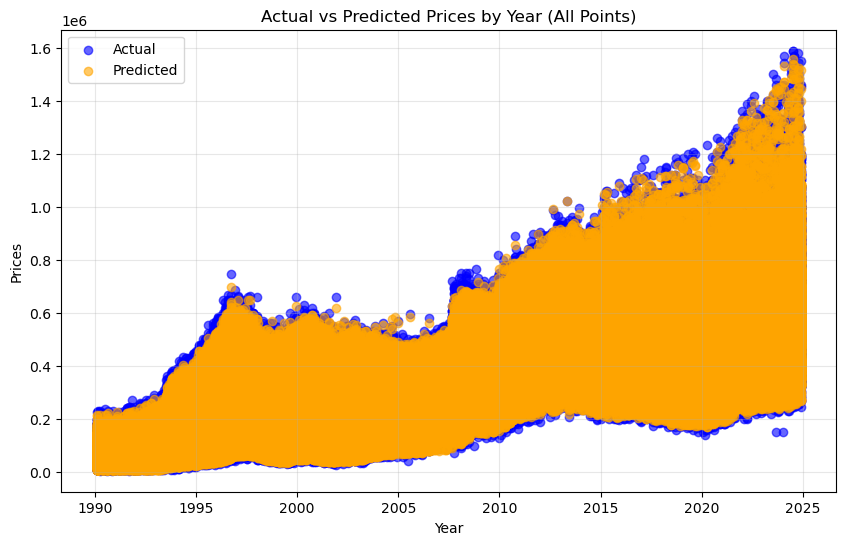

In [31]:
# Create a DataFrame to hold predictions and actual values
results_df = pd.DataFrame({
    'year': X['new_date'],  # Ensure this is the year column
    'y': y,
    'ensemble_pred': ensemble_pred
})

# Scatter plot for all points
plt.figure(figsize=(10, 6))
plt.scatter(results_df['year'], results_df['y'], color='blue', label='Actual', alpha=0.6)
plt.scatter(results_df['year'], results_df['ensemble_pred'], color='orange', label='Predicted', alpha=0.6)

# Add labels, title, and legend
plt.xlabel("Year")
plt.ylabel("Prices")
plt.title("Actual vs Predicted Prices by Year (All Points)")
plt.legend()
plt.grid(alpha=0.3)

# Show the plot
plt.show()


Mean Percentage Error: 5.94%
Max Percentage Error: 286.38%
Min Percentage Error: 0.00%


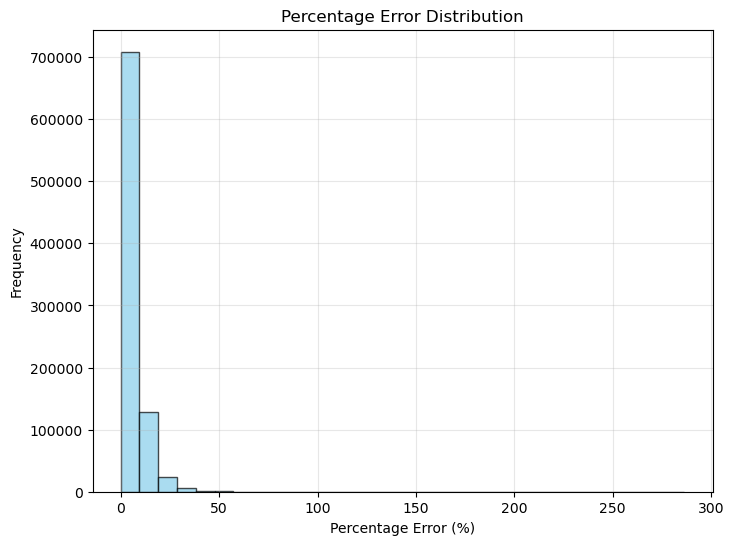

In [32]:
# Calculate the percentage error for each prediction
percentage_error = np.abs((y - ensemble_pred) / y) * 100

# Calculate the mean percentage error (optional, for overall performance)
mean_percentage_error = np.mean(percentage_error)

# Display some statistics
print(f"Mean Percentage Error: {mean_percentage_error:.2f}%")
print(f"Max Percentage Error: {np.max(percentage_error):.2f}%")
print(f"Min Percentage Error: {np.min(percentage_error):.2f}%")

# Plot percentage error distribution
plt.figure(figsize=(8, 6))
plt.hist(percentage_error, bins=30, color='skyblue', edgecolor='black', alpha=0.7)
plt.title("Percentage Error Distribution")
plt.xlabel("Percentage Error (%)")
plt.ylabel("Frequency")
plt.grid(alpha=0.3)
plt.show()


In [70]:
data = pd.read_csv("ResaleflatpricesbasedonregistrationdatefromJan2017onwards.csv")

In [71]:
data.columns

Index(['month', 'town', 'flat_type', 'block', 'street_name', 'storey_range',
       'floor_area_sqm', 'flat_model', 'lease_commence_date',
       'remaining_lease', 'resale_price'],
      dtype='object')

In [72]:
data = data.drop(columns = [ 'block', 'street_name',
       'flat_model', 'remaining_lease'])

In [73]:
data.head()

month        town flat_type storey_range  floor_area_sqm  \
0  2017-01  ANG MO KIO    2 ROOM     10 TO 12            44.0   
1  2017-01  ANG MO KIO    3 ROOM     01 TO 03            67.0   
2  2017-01  ANG MO KIO    3 ROOM     01 TO 03            67.0   
3  2017-01  ANG MO KIO    3 ROOM     04 TO 06            68.0   
4  2017-01  ANG MO KIO    3 ROOM     01 TO 03            67.0   

   lease_commence_date  resale_price  
0                 1979      232000.0  
1                 1978      250000.0  
2                 1980      262000.0  
3                 1980      265000.0  
4                 1980      265000.0

In [74]:
# Split the 'month' column into 'year' and 'month'
data[['year', 'month']] = data['month'].str.split('-', expand=True)

# Convert 'year' and 'month' to numeric
data['year'] = pd.to_numeric(data['year'])
data['month'] = pd.to_numeric(data['month'])

# Calculate the new date
data['new_date'] = data['year'] + data['month'] / 12

# Drop the original 'month' column
data = data.drop(columns=['year','month'])

# Display the first few rows
data.head()


town flat_type storey_range  floor_area_sqm  lease_commence_date  \
0  ANG MO KIO    2 ROOM     10 TO 12            44.0                 1979   
1  ANG MO KIO    3 ROOM     01 TO 03            67.0                 1978   
2  ANG MO KIO    3 ROOM     01 TO 03            67.0                 1980   
3  ANG MO KIO    3 ROOM     04 TO 06            68.0                 1980   
4  ANG MO KIO    3 ROOM     01 TO 03            67.0                 1980   

   resale_price     new_date  
0      232000.0  2017.083333  
1      250000.0  2017.083333  
2      262000.0  2017.083333  
3      265000.0  2017.083333  
4      265000.0  2017.083333

In [75]:
data['town'] = data['town'].replace('/', '_', regex=True)
print(data['town'].unique())

['ANG MO KIO' 'BEDOK' 'BISHAN' 'BUKIT BATOK' 'BUKIT MERAH' 'BUKIT PANJANG'
 'BUKIT TIMAH' 'CENTRAL AREA' 'CHOA CHU KANG' 'CLEMENTI' 'GEYLANG'
 'HOUGANG' 'JURONG EAST' 'JURONG WEST' 'KALLANG_WHAMPOA' 'MARINE PARADE'
 'PASIR RIS' 'PUNGGOL' 'QUEENSTOWN' 'SEMBAWANG' 'SENGKANG' 'SERANGOON'
 'TAMPINES' 'TOA PAYOH' 'WOODLANDS' 'YISHUN']


In [76]:
data['flat_type'] = data['flat_type'].replace('MULTI GENERATION','MULTI-GENERATION',regex = True)
print(data['flat_type'].unique())

['2 ROOM' '3 ROOM' '4 ROOM' '5 ROOM' 'EXECUTIVE' '1 ROOM'
 'MULTI-GENERATION']


In [77]:
# Split the range into start and end, then compute the midpoint
data[['start', 'end']] = data['storey_range'].str.split(' TO ', expand=True).astype(int)
data['range_numeric'] = (data['start'] + data['end']) / 2  # Compute midpoint

# Drop the auxiliary columns
data.drop(columns=['start', 'end','storey_range'], inplace=True)
print(data['range_numeric'].unique())


[11.  2.  5.  8. 14. 20. 23. 17. 35. 29. 38. 50. 26. 41. 32. 47. 44.]


In [78]:
# Define a mapping of towns to districts
district_mapping = {
    'ANG MO KIO': 'North-East',
    'BEDOK': 'East',
    'BISHAN': 'Central',
    'BUKIT BATOK': 'West',
    'BUKIT MERAH': 'Central',
    'BUKIT TIMAH': 'Central',
    'CENTRAL AREA': 'Central',
    'CHOA CHU KANG': 'West',
    'CLEMENTI': 'West',
    'GEYLANG': 'Central',
    'HOUGANG': 'North-East',
    'JURONG EAST': 'West',
    'JURONG WEST': 'West',
    'KALLANG_WHAMPOA': 'Central',
    'MARINE PARADE': 'East',
    'QUEENSTOWN': 'Central',
    'SENGKANG': 'North-East',
    'SERANGOON': 'North-East',
    'TAMPINES': 'East',
    'TOA PAYOH': 'Central',
    'WOODLANDS': 'North',
    'YISHUN': 'North',
    'LIM CHU KANG': 'West',
    'SEMBAWANG': 'North',
    'BUKIT PANJANG': 'West',
    'PASIR RIS': 'East',
    'PUNGGOL': 'North-East',
}

# Create a new column for districts
data['district'] = data['town'].map(district_mapping)
data = data.drop(columns='town')
# Verify the new column
print(data.head())


  flat_type  floor_area_sqm  lease_commence_date  resale_price     new_date  \
0    2 ROOM            44.0                 1979      232000.0  2017.083333   
1    3 ROOM            67.0                 1978      250000.0  2017.083333   
2    3 ROOM            67.0                 1980      262000.0  2017.083333   
3    3 ROOM            68.0                 1980      265000.0  2017.083333   
4    3 ROOM            67.0                 1980      265000.0  2017.083333   

   range_numeric    district  
0           11.0  North-East  
1            2.0  North-East  
2            2.0  North-East  
3            5.0  North-East  
4            2.0  North-East  


In [79]:

# Initialize an empty list to store the selected rows
rows = []

# Iterate through each row in the DataFrame
for _, row in data.iterrows():
    # Check if the flat_type is not EXECUTIVE or MULTI_GENERATION
    if row['flat_type'] != 'EXECUTIVE' and row['flat_type'] != 'MULTI-GENERATION':
        # Add the row to the list
        rows.append(row)

# Convert the list of rows to a DataFrame
df = pd.DataFrame(rows)

# Display the first few rows of the updated DataFrame
df.head()


flat_type  floor_area_sqm  lease_commence_date  resale_price     new_date  \
0    2 ROOM            44.0                 1979      232000.0  2017.083333   
1    3 ROOM            67.0                 1978      250000.0  2017.083333   
2    3 ROOM            67.0                 1980      262000.0  2017.083333   
3    3 ROOM            68.0                 1980      265000.0  2017.083333   
4    3 ROOM            67.0                 1980      265000.0  2017.083333   

   range_numeric    district  
0           11.0  North-East  
1            2.0  North-East  
2            2.0  North-East  
3            5.0  North-East  
4            2.0  North-East

In [80]:
df['flat_type'].unique()


array(['2 ROOM', '3 ROOM', '4 ROOM', '5 ROOM', '1 ROOM'], dtype=object)

In [81]:
# Initialize an empty list to store the selected rows
rows = []

# Iterate through each row in the DataFrame
for _, row in data.iterrows():
    # Check if the flat_type is not EXECUTIVE or MULTI_GENERATION
    if row['new_date'] > 2025:
        # Add the row to the list
        rows.append(row)

# Convert the list of rows to a DataFrame
df = pd.DataFrame(rows)

# Display the first few rows of the updated DataFrame
df.head()

flat_type  floor_area_sqm  lease_commence_date  resale_price  \
197012    2 ROOM            44.0                 1978      318000.0   
197013    3 ROOM            70.0                 2012      650000.0   
197014    3 ROOM            68.0                 1981      410000.0   
197015    3 ROOM            73.0                 1977      448000.0   
197016    3 ROOM            68.0                 1980      415000.0   

           new_date  range_numeric    district  
197012  2025.083333           11.0  North-East  
197013  2025.083333           14.0  North-East  
197014  2025.083333           11.0  North-East  
197015  2025.083333            5.0  North-East  
197016  2025.083333           14.0  North-East

In [82]:
df['new_date'].unique()

array([2025.08333333])

In [83]:
df = df[['new_date','flat_type', 'district', 'range_numeric' ,'floor_area_sqm', 'lease_commence_date','resale_price']]
df.head()

new_date flat_type    district  range_numeric  floor_area_sqm  \
197012  2025.083333    2 ROOM  North-East           11.0            44.0   
197013  2025.083333    3 ROOM  North-East           14.0            70.0   
197014  2025.083333    3 ROOM  North-East           11.0            68.0   
197015  2025.083333    3 ROOM  North-East            5.0            73.0   
197016  2025.083333    3 ROOM  North-East           14.0            68.0   

        lease_commence_date  resale_price  
197012                 1978      318000.0  
197013                 2012      650000.0  
197014                 1981      410000.0  
197015                 1977      448000.0  
197016                 1980      415000.0

In [84]:
df.to_csv('2025_data.csv',index=False)

In [85]:
data = pd.read_csv('2025_data.csv')
data.head()


new_date flat_type    district  range_numeric  floor_area_sqm  \
0  2025.083333    2 ROOM  North-East           11.0            44.0   
1  2025.083333    3 ROOM  North-East           14.0            70.0   
2  2025.083333    3 ROOM  North-East           11.0            68.0   
3  2025.083333    3 ROOM  North-East            5.0            73.0   
4  2025.083333    3 ROOM  North-East           14.0            68.0   

   lease_commence_date  resale_price  
0                 1978      318000.0  
1                 2012      650000.0  
2                 1981      410000.0  
3                 1977      448000.0  
4                 1980      415000.0

In [91]:
loaded_preprocessor = joblib.load('preprocessor/preprocessor_data.pkl')

In [93]:
# Load the preprocessor and transform the new data
transformed_new_data = loaded_preprocessor.transform(data)
# Extract feature names from the transformers
categorical_columns = ['district', 'flat_type']
numerical_columns = ['floor_area_sqm', 'range_numeric']

num_feature_names = numerical_columns
cat_feature_names = loaded_preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_columns)
remainder_feature_names = [col for col in data.columns if col not in numerical_columns + categorical_columns]

# Combine all feature names
all_feature_names = list(num_feature_names) + list(cat_feature_names) + remainder_feature_names

# Create a DataFrame with feature names
transformed_new_data = pd.DataFrame(transformed_new_data, columns=all_feature_names)
print("Transformed New Data:")
print(transformed_new_data)

Transformed New Data:
     floor_area_sqm  range_numeric  district_East  district_North  \
0         -2.165659       0.663203            0.0             0.0   
1         -0.980385       1.276691            0.0             0.0   
2         -1.071560       0.663203            0.0             0.0   
3         -0.843622      -0.563772            0.0             0.0   
4         -1.071560       1.276691            0.0             0.0   
..              ...            ...            ...             ...   
573        0.888702      -1.177259            0.0             1.0   
574        0.979877       0.663203            0.0             1.0   
575        1.390164       0.049716            0.0             1.0   
576        1.618102       0.663203            0.0             1.0   
577        2.484264      -0.563772            0.0             1.0   

     district_North-East  district_West  flat_type_2 ROOM  flat_type_3 ROOM  \
0                    1.0            0.0               1.0             

c:\Users\firas\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:202: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [94]:
transformed_new_data.head()


floor_area_sqm  range_numeric  district_East  district_North  \
0       -2.165659       0.663203            0.0             0.0   
1       -0.980385       1.276691            0.0             0.0   
2       -1.071560       0.663203            0.0             0.0   
3       -0.843622      -0.563772            0.0             0.0   
4       -1.071560       1.276691            0.0             0.0   

   district_North-East  district_West  flat_type_2 ROOM  flat_type_3 ROOM  \
0                  1.0            0.0               1.0               0.0   
1                  1.0            0.0               0.0               1.0   
2                  1.0            0.0               0.0               1.0   
3                  1.0            0.0               0.0               1.0   
4                  1.0            0.0               0.0               1.0   

   flat_type_4 ROOM  flat_type_5 ROOM     new_date  lease_commence_date  \
0               0.0               0.0  2025.083333               1978.0   
1               0.0               0.0  2025.083333               2012.0   
2               0.0               0.0  2025.083333               1981.0   
3               0.0               0.0  2025.083333               1977.0   
4               0.0               0.0  2025.083333               1980.0   

   resale_price  
0      318000.0  
1      650000.0  
2      410000.0  
3      448000.0  
4      415000.0

In [97]:
X = transformed_new_data.drop(columns='resale_price')
y = transformed_new_data['resale_price']

In [95]:
model_rf = joblib.load('models/new_model_rf.pkl')
model_xgb = joblib.load('models/new_model_xgb.pkl')
model_cat = joblib.load('models/new_model_cat.pkl')

In [98]:
best_weight = [0.32,0.23,0.45]
y_pred = model_xgb.predict(X)*best_weight[0]+ model_rf.predict(X)*best_weight[1] +model_cat.predict(X)*best_weight[2]
print("Resale Valuation")
print(y_pred)

Resale Valuation
[ 321172.40982375  563603.26247386  426886.44611216  443268.37148652
  417818.15070444  473803.57867664  421490.44761134  427716.31546911
  473803.57867664  438548.18658075  480096.66913344  442555.62686093
  476037.63560824  391054.41043055  391054.41043055  476160.66147095
  416477.09820653  507820.66737524  414876.03431434  423048.14496459
  411123.18795741  469933.04742328  464808.84588448  398355.33582342
  421490.44761134  563656.59086341  526547.89867614  558603.21561766
  547555.68666997  696467.84764098  645605.03829591  846060.31569274
  972584.82409467  416262.25792844  423834.81644562  469480.9653294
  411281.17004701  418992.47239163  414267.44389039  441895.17937179
  424301.45296838  444302.51721326  407486.64087593  684321.75989987
  538226.82779442  534570.68807962  540633.72074563  568322.2397631
  567220.14156312  550601.92095445  479174.53742423  641194.80700476
  768932.83503705  735329.31654443  471793.8063558   394263.12076225
  627429.94328365  

In [104]:
data['predictions'] = y_pred
data['differences'] = y - y_pred
# Calculate percentage error for each prediction
data['percentage_error'] = abs((data['resale_price'] - data['predictions']) / data['resale_price']) * 100
data.head()

new_date flat_type    district  range_numeric  floor_area_sqm  \
0  2025.083333    2 ROOM  North-East           11.0            44.0   
1  2025.083333    3 ROOM  North-East           14.0            70.0   
2  2025.083333    3 ROOM  North-East           11.0            68.0   
3  2025.083333    3 ROOM  North-East            5.0            73.0   
4  2025.083333    3 ROOM  North-East           14.0            68.0   

   lease_commence_date  resale_price    predictions   differences  \
0                 1978      318000.0  321172.409824  -3172.409824   
1                 2012      650000.0  563603.262474  86396.737526   
2                 1981      410000.0  426886.446112 -16886.446112   
3                 1977      448000.0  443268.371487   4731.628513   
4                 1980      415000.0  417818.150704  -2818.150704   

   percentage_error  
0          0.997613  
1         13.291806  
2          4.118645  
3          1.056167  
4          0.679072

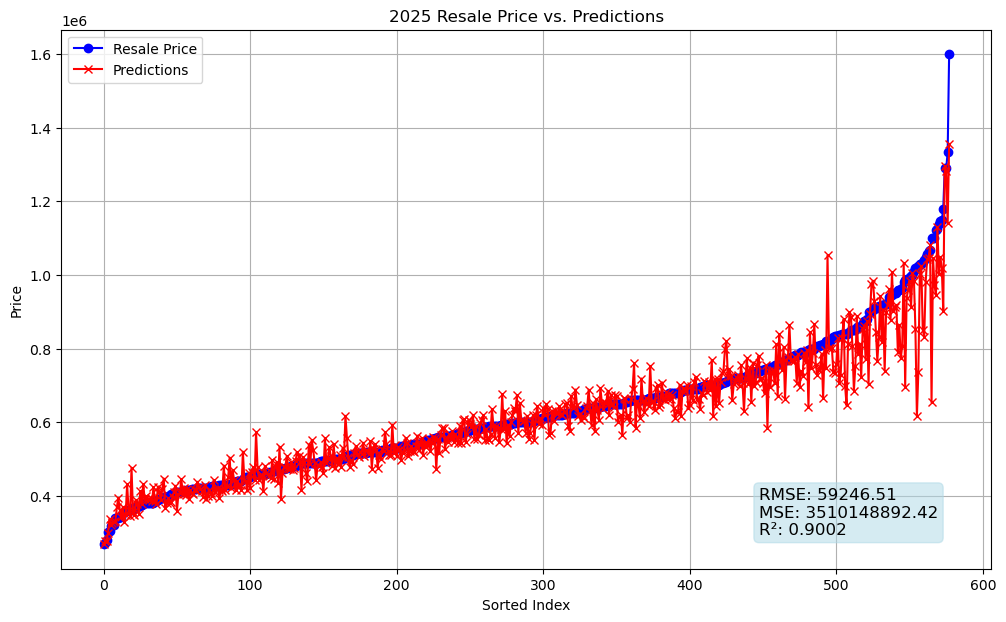

In [107]:
# Calculate metrics
y_true = data['resale_price']
y_pred = data['predictions']
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_true, y_pred)

# Sort data by actual resale price (y_true)
data_sorted = data.sort_values(by='resale_price').reset_index(drop=True)

# Recalculate metrics for sorted data (metrics remain unchanged)
y_true_sorted = data_sorted['resale_price']
y_pred_sorted = data_sorted['predictions']

# Plotting sorted resale price vs. predictions with metrics displayed
plt.figure(figsize=(12, 7))
plt.plot(data_sorted.index, y_true_sorted, color='blue', marker='o', label='Resale Price')
plt.plot(data_sorted.index, y_pred_sorted, color='red', marker='x', label='Predictions')

# Display the metrics on the plot
metrics_text = f"RMSE: {rmse:.2f}\nMSE: {mse:.2f}\nR²: {r2:.4f}"
plt.gca().text(0.75, 0.15, metrics_text, transform=plt.gca().transAxes, fontsize=12, verticalalignment='top',
               bbox=dict(boxstyle="round", alpha=0.5, color="lightblue"))

plt.xlabel('Sorted Index')
plt.ylabel('Price')
plt.title('2025 Resale Price vs. Predictions')
plt.legend()
plt.grid(True)
plt.show()


Mean Percentage Error: 5.15%
Max Percentage Error: 40.58%
Min Percentage Error: 0.00%


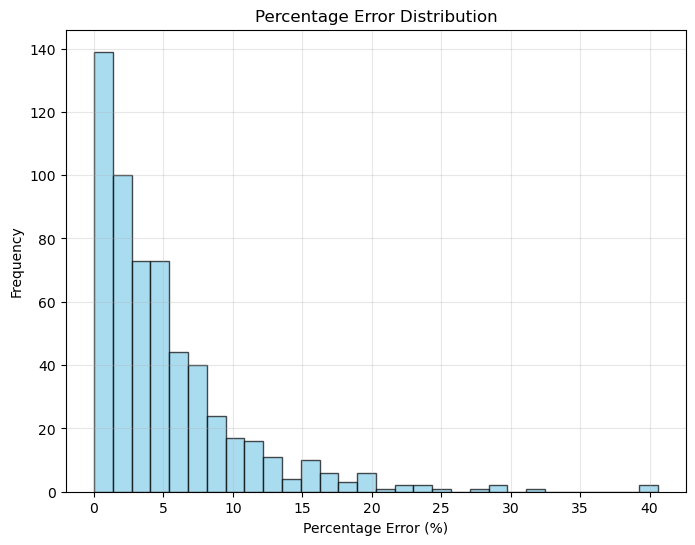

In [106]:
# Calculate the percentage error for each prediction
percentage_error = np.abs((y - y_pred) / y) * 100

# Calculate the mean percentage error (optional, for overall performance)
mean_percentage_error = np.mean(percentage_error)

# Display some statistics
print(f"Mean Percentage Error: {mean_percentage_error:.2f}%")
print(f"Max Percentage Error: {np.max(percentage_error):.2f}%")
print(f"Min Percentage Error: {np.min(percentage_error):.2f}%")

# Plot percentage error distribution
plt.figure(figsize=(8, 6))
plt.hist(percentage_error, bins=30, color='skyblue', edgecolor='black', alpha=0.7)
plt.title("Percentage Error Distribution")
plt.xlabel("Percentage Error (%)")
plt.ylabel("Frequency")
plt.grid(alpha=0.3)
plt.show()

In [108]:
data.head()


new_date flat_type    district  range_numeric  floor_area_sqm  \
0  2025.083333    2 ROOM  North-East           11.0            44.0   
1  2025.083333    3 ROOM  North-East           14.0            70.0   
2  2025.083333    3 ROOM  North-East           11.0            68.0   
3  2025.083333    3 ROOM  North-East            5.0            73.0   
4  2025.083333    3 ROOM  North-East           14.0            68.0   

   lease_commence_date  resale_price    predictions   differences  \
0                 1978      318000.0  321172.409824  -3172.409824   
1                 2012      650000.0  563603.262474  86396.737526   
2                 1981      410000.0  426886.446112 -16886.446112   
3                 1977      448000.0  443268.371487   4731.628513   
4                 1980      415000.0  417818.150704  -2818.150704   

   percentage_error  
0          0.997613  
1         13.291806  
2          4.118645  
3          1.056167  
4          0.679072

In [109]:
data.to_csv("dataset/2025_predictions.csv")

In [3]:
import numpy as np
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import joblib
import pandas as pd


In [4]:
data = pd.read_csv("dataset/housing_new.csv")


In [9]:
data.head()
data= data.drop(columns=['Unnamed: 0.1','Unnamed: 0'])

In [10]:
loaded_preprocessor = joblib.load('preprocessor/preprocessor.pkl')
transformed_data = loaded_preprocessor.transform(data)
# Extract feature names from the transformers
categorical_columns = ['district', 'flat_type']
numerical_columns = [ 'floor_area_sqm', 'range_numeric']

num_feature_names = numerical_columns
cat_feature_names = loaded_preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_columns)
remainder_feature_names = [col for col in data.columns if col not in numerical_columns + categorical_columns]

# Combine all feature names
all_feature_names = list(num_feature_names) + list(cat_feature_names) + remainder_feature_names

# Create a DataFrame with feature names
transformed_data = pd.DataFrame(transformed_data, columns=all_feature_names)


In [12]:
X = transformed_data.drop('resale_price', axis=1)
y= transformed_data['resale_price']
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [13]:

# Define hyperparameters for each model
catboost_params = {
    'iterations': 2864,
    'depth': 12,
    'learning_rate': 0.1168,
    'l2_leaf_reg': 1.8333,
    'bagging_temperature': 0.73496,
    'random_strength': 0.0017,
    'border_count': 161,
    'grow_policy': 'SymmetricTree',
    'min_data_in_leaf': 6,
    'one_hot_max_size': 5
}

xgb_params = {
    'learning_rate': 0.1054,
    'n_estimators': 925,
    'max_depth': 10,
    'subsample': 0.9951,
    'colsample_bytree': 0.6003,
    'min_child_weight': 3,
    'reg_alpha': 0.3862,
    'reg_lambda': 4.5919,
    'gamma': 0.6422
}

rf_params = {
    'n_estimators': 138,
    'max_depth': 22,
    'min_samples_split': 12,
    'min_samples_leaf': 7,
    'max_features': 0.6284,
    'bootstrap': False
}

# Train models with different random states
random_states = [0, 42, 100, 2023, 999]
results = []

In [14]:


for state in random_states:
    print(f"Training with random_state={state}")
    
    # CatBoost
    cat_model = CatBoostRegressor(**catboost_params, random_seed=state, verbose=0)
    cat_model.fit(X_train, y_train)
    cat_pred = cat_model.predict(X_test)
    cat_rmse = mean_squared_error(y_test, cat_pred, squared=False)
    
    # XGBoost
    xgb_model = XGBRegressor(**xgb_params, random_state=state)
    xgb_model.fit(X_train, y_train)
    xgb_pred = xgb_model.predict(X_test)
    xgb_rmse = mean_squared_error(y_test, xgb_pred, squared=False)
    
    # Random Forest
    rf_model = RandomForestRegressor(**rf_params, random_state=state)
    rf_model.fit(X_train, y_train)
    rf_pred = rf_model.predict(X_test)
    rf_rmse = mean_squared_error(y_test, rf_pred, squared=False)
    
    results.append({
        'random_state': state,
        'CatBoost_RMSE': cat_rmse,
        'XGBoost_RMSE': xgb_rmse,
        'RandomForest_RMSE': rf_rmse
    })

# Display results
results_df = pd.DataFrame(results)
print(results_df)


Training with random_state=0
Training with random_state=42
Training with random_state=100
Training with random_state=2023
Training with random_state=999
   random_state  CatBoost_RMSE  XGBoost_RMSE  RandomForest_RMSE
0             0       4.027127      4.089171           4.030783
1            42       4.027661      4.087902           4.033549
2           100       4.021699      4.089420           4.032625
3          2023       4.028101      4.092154           4.030998
4           999       4.024085      4.085500           4.030175


ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (3,) and arg 1 with shape (2,).

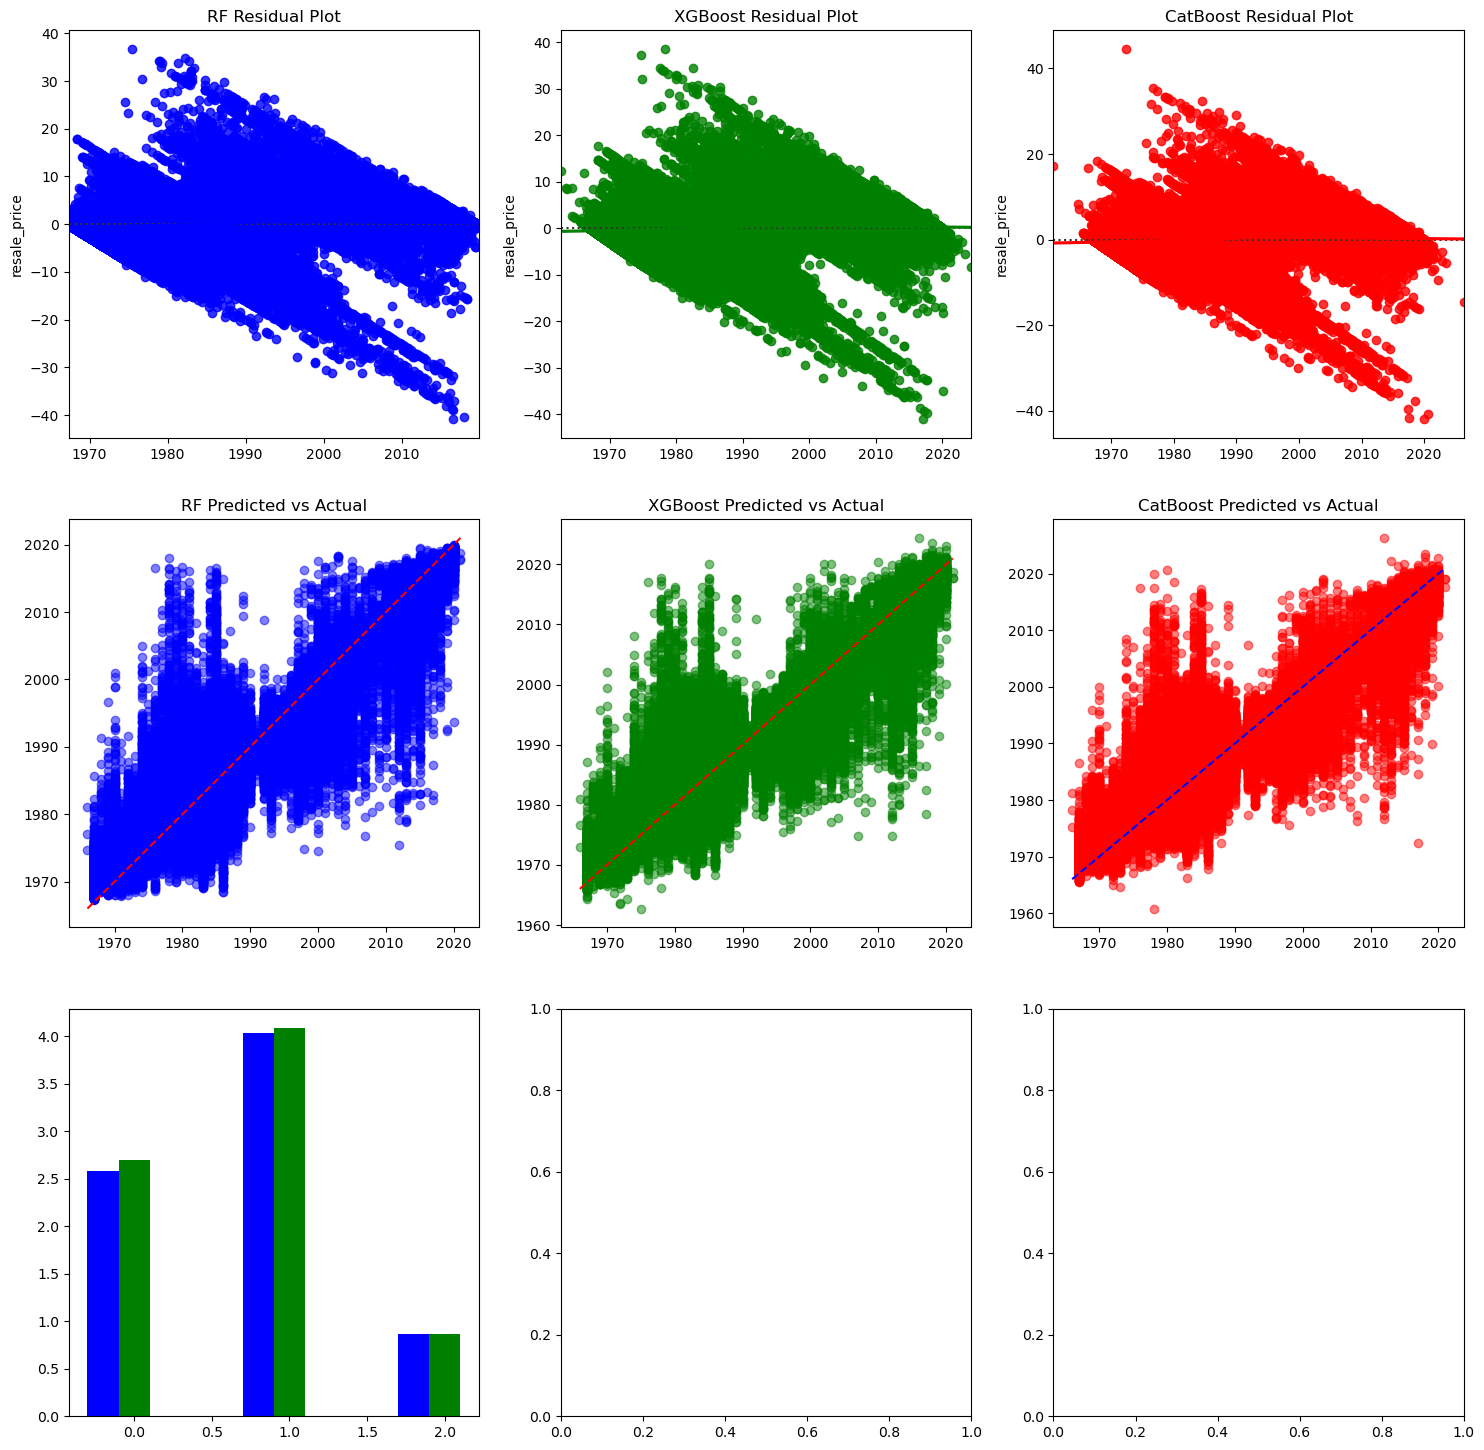

In [17]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.ensemble import RandomForestRegressor


cat_model = CatBoostRegressor(**catboost_params, random_seed=100, verbose=0)
cat_model.fit(X_train, y_train)
cat_pred = cat_model.predict(X_test)


# XGBoost
xgb_model = XGBRegressor(**xgb_params, random_state=999)
xgb_model.fit(X_train, y_train)
xgb_pred = xgb_model.predict(X_test)


# Random Forest
rf_model = RandomForestRegressor(**rf_params, random_state=999)
rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_test)

# Fit the models

# Calculate Metrics for each model
mae_rf = mean_absolute_error(y_test, rf_pred)
mse_rf = mean_squared_error(y_test, rf_pred)
rmse_rf = np.sqrt(mse_rf)
r2_rf = r2_score(y_test, rf_pred)

mae_xgb = mean_absolute_error(y_test, xgb_pred)
mse_xgb = mean_squared_error(y_test, xgb_pred)
rmse_xgb = np.sqrt(mse_xgb)
r2_xgb = r2_score(y_test, xgb_pred)

mae_cat = mean_absolute_error(y_test, cat_pred)
mse_cat = mean_squared_error(y_test, cat_pred)
rmse_cat = np.sqrt(mse_cat)
r2_cat = r2_score(y_test, cat_pred)

# Set up subplots for all visuals
fig, axes = plt.subplots(3, 3, figsize=(18, 18))

# Residual plots
sns.residplot(x=rf_pred, y=y_test, lowess=True, color="blue", ax=axes[0, 0])
axes[0, 0].set_title('RF Residual Plot')

sns.residplot(x=xgb_pred, y=y_test, lowess=True, color="green", ax=axes[0, 1])
axes[0, 1].set_title('XGBoost Residual Plot')

sns.residplot(x=cat_pred, y=y_test, lowess=True, color="red", ax=axes[0, 2])
axes[0, 2].set_title('CatBoost Residual Plot')

# Prediction vs Actual plots
axes[1, 0].scatter(y_test, rf_pred, color='blue', alpha=0.5)
axes[1, 0].plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')
axes[1, 0].set_title('RF Predicted vs Actual')

axes[1, 1].scatter(y_test, xgb_pred, color='green', alpha=0.5)
axes[1, 1].plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')
axes[1, 1].set_title('XGBoost Predicted vs Actual')

axes[1, 2].scatter(y_test, cat_pred, color='red', alpha=0.5)
axes[1, 2].plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='blue', linestyle='--')
axes[1, 2].set_title('CatBoost Predicted vs Actual')

# Bar plot to compare MAE, RMSE, and R²
metrics = ['MAE', 'RMSE', 'R²']
rf_metrics = [mae_rf, rmse_rf, r2_rf]
xgb_metrics = [mae_xgb, rmse_xgb, r2_xgb]
cat_metrics = [mae_cat, rmse_cat]

x = np.arange(len(metrics))  # The label locations
width = 0.2  # The width of the bars

axes[2, 0].bar(x - width, rf_metrics, width, label='RF', color='blue')
axes[2, 0].bar(x, xgb_metrics, width, label='XGBoost', color='green')
axes[2, 0].bar(x + width, cat_metrics, width, label='CatBoost', color='red')

axes[2, 0].set_xlabel('Metric')
axes[2, 0].set_ylabel('Value')
axes[2, 0].set_title('Comparison of MAE, RMSE, R²')
axes[2, 0].set_xticks(x)
axes[2, 0].set_xticklabels(metrics)
axes[2, 0].legend()

# Learning Curves
train_sizes_rf, train_scores_rf, test_scores_rf = learning_curve(rf_model, X_train, y_train, cv=5)
train_sizes_xgb, train_scores_xgb, test_scores_xgb = learning_curve(xgb_model, X_train, y_train, cv=5)
train_sizes_cat, train_scores_cat, test_scores_cat = learning_curve(catboost_model, X_train, y_train, cv=5)

axes[2, 1].plot(train_sizes_rf, test_scores_rf.mean(axis=1), label="RF", color='blue')
axes[2, 1].plot(train_sizes_xgb, test_scores_xgb.mean(axis=1), label="XGBoost", color='green')
axes[2, 1].plot(train_sizes_cat, test_scores_cat.mean(axis=1), label="CatBoost", color='red')

axes[2, 1].set_title("Learning Curve Comparison")
axes[2, 1].set_xlabel("Training Set Size")
axes[2, 1].set_ylabel("Test Score (R²)")
axes[2, 1].legend()

# Feature importance comparison
feature_names = ['Feature1', 'Feature2', 'Feature3', 'Feature4']  # Example feature names
importance_rf = rf_model.feature_importances_
importance_xgb = xgb_model.feature_importances_
importance_cat = catboost_model.get_feature_importance()

axes[2, 2].barh(feature_names, importance_rf, color='blue', alpha=0.6, label='Random Forest')
axes[2, 2].barh(feature_names, importance_xgb, color='green', alpha=0.6, label='XGBoost')
axes[2, 2].barh(feature_names, importance_cat, color='red', alpha=0.6, label='CatBoost')

axes[2, 2].set_title('Feature Importance Comparison')
axes[2, 2].legend()

# Adjust layout
plt.tight_layout()
plt.show()